In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
import csv
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from solar_module import SolarModule, generate_shading, generate_gaussian
from solar_cell import all_series_bypass, SP_interconnection, TCT_interconnection
from string_to_embedding import string_to_embedding, super_to_embedding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/mlima/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
class Model(nn.Module):
    def __init__(self, imgchannels=1, fdim=8, zdim=32, mdim=4096, kern=3, imgshape=(3,3), stride=1, pad=1):
        
        super(Model, self).__init__()
        
        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 8 convolutional features, with a square kernel size of 2
        self.conv1 = nn.Conv2d(imgchannels, fdim, kern, stride, pad) # (1, 8, 3, 1)

        # Second 2D convolutional layer, taking in the 8 input layers,
        # outputting 32 convolutional features, with a square kernel size of 2
        self.conv2 = nn.Conv2d(fdim, zdim, kern, stride, pad) # (8, 32, 3, 1, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)
        
        ldim = zdim*imgshape[0]*imgshape[1]
        self.ldim = ldim

        # First fully connected layer
        self.fc1 = nn.Linear(ldim, mdim) #add a middle linear layer, with size 
        self.fc3 = nn.Linear(mdim, mdim)
        outdim = (imgshape[0]*imgshape[1])**2*3+imgshape[0]*imgshape[1]*2
        #outdim = (imgshape[0]*imgshape[1])**2*3
        self.fc2 = nn.Linear(mdim, outdim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(x.shape)
        
        x = self.conv2(x)
        x = F.relu(x)
        #print(x.shape)
        
        #x = self.dropout1(x)
        x = x.view(-1, self.ldim)
        #print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        #print(x.shape)
        #x = self.dropout2(x)
        x = self.fc2(x)
        #print(x.shape)
        
        x = F.relu(x)
        #x = x.bool()
        
        return x

model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)
for param in model.parameters():
  print(param.data)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu
tensor([[[[-0.1840, -0.0906, -0.2388],
          [-0.2054, -0.3106, -0.1792],
          [ 0.1036, -0.2751, -0.1153]]],


        [[[-0.0182,  0.2735, -0.0046],
          [ 0.0920, -0.2687, -0.2312],
          [-0.3201,  0.1715,  0.0008]]],


        [[[-0.1032, -0.0759,  0.2484],
          [ 0.2068, -0.2805, -0.1020],
          [ 0.2474, -0.2460,  0.0910]]],


        [[[ 0.0950,  0.2227, -0.3046],
          [ 0.3138,  0.2422,  0.2441],
          [-0.1917,  0.0450, -0.1814]]],


        [[[-0.3113,  0.0543,  0.2649],
          [-0.2984, -0.2832, -0.2070],
          [-0.1350, -0.0826, -0.0519]]],


        [[[-0.2002, -0.1905,  0.3332],

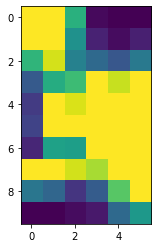

In [3]:
rand_smap = generate_gaussian(10, 10, 6)
plt.imshow(rand_smap)


In [ ]:
rand_smap = torch.Tensor(np.expand_dims(rand_smap,0))
print(rand_smap)
print(rand_smap.shape)


In [ ]:
result = model(rand_smap)
print(result)
print(result.shape)

In [23]:
## convert output to embedding using SolarModule object
model.eval()
with torch.no_grad():
    out_data = model(rand_smap)
    #out_data = out_data.type(torch.bool)
    #print(out_data)
    
    out_data = out_data.reshape(10920).cpu().numpy()
    
embedding, terminal_array = out_data[:10800], out_data[10800:]
print(embedding.shape)
print(terminal_array.shape)
embedding = embedding.reshape(10, 6, 10, 6, 3)
terminal_array = terminal_array.reshape(10, 6, 2)
moduleobj = SolarModule(10,6)
moduleobj.embedding = embedding
moduleobj.terminal_array = terminal_array

#Fix (0,0) and (2,2) to be ground and positive
#moduleobj.connect_to_ground(0,0)
#moduleobj.connect_to_pos(9,5)

print(moduleobj.filter_embedding())
moduleobj.make_netlist()
moduleobj.simulate()
print(moduleobj.MPP)
moduleobj.plot_netlist()

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


Text(0.5, 1.0, 'Shading Map 4316')

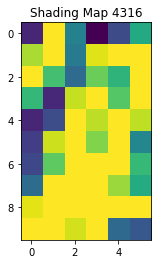

In [4]:
"""Load in Dataset (training_data.csv)"""
read_in = pd.read_csv("shading_series.csv")
def convert_to_array(string):
    a = np.matrix(string).reshape(10, 6)
    a = np.array(a)
    return a
shading_series = [convert_to_array(s) for s in read_in['Shading Maps']]
s = random.randint(0, 10000)
plt.imshow(shading_series[s])
plt.title("Shading Map " + str(s))

In [6]:
read_in = pd.read_csv("embedding_series.csv", header=0, names=['SuperString'], usecols=[1])
configurations = [x for x in read_in['SuperString']]


In [7]:
""" Create dataset data frame """
df = pd.read_csv("training_data.csv",dtype={'MPP':float, 'VMP':float, 'IMP':float, 'VOC':float, 'ISC':float, 'FF':float})
print(df)

         Shading Map #  SuperString #         MPP    VMP         IMP    VOC  \
0                    0              0  227.435930   0.67  339.456612   0.75   
1                    0              1   14.058677   3.59    3.916066   3.78   
2                    0              2  179.316049   0.67  267.635894   0.76   
3                    0              3  185.737293   0.67  277.219840   0.76   
4                    0              4  143.931344   0.67  214.822901   0.76   
...                ...            ...         ...    ...         ...    ...   
3706427           3813            834   30.880000   3.41    9.060000   3.84   
3706428           3813            835    0.040000  19.00    0.000000  37.99   
3706429           3813            836    0.040000  18.99    0.000000  37.98   
3706430           3813            837   20.290000   2.08    9.760000   2.30   
3706431           3813            838    0.040000  19.74    0.000000  39.48   

                ISC        FF  
0        353.587870

In [8]:
"""Create Normalised Column"""
normalised = []
for idx, x in enumerate(df['Shading Map #']):
    shading_map = shading_series[x].flatten()
    mpp = df.iloc[idx, 2]
    normalised.append(mpp/sum(shading_map))

In [148]:
print(max(normalised))

0.6449678511000733


In [10]:
df['Normalised MPP'] = normalised
print(df)

         Shading Map #  SuperString #         MPP    VMP         IMP    VOC  \
0                    0              0  227.435930   0.67  339.456612   0.75   
1                    0              1   14.058677   3.59    3.916066   3.78   
2                    0              2  179.316049   0.67  267.635894   0.76   
3                    0              3  185.737293   0.67  277.219840   0.76   
4                    0              4  143.931344   0.67  214.822901   0.76   
...                ...            ...         ...    ...         ...    ...   
3706427           3813            834   30.880000   3.41    9.060000   3.84   
3706428           3813            835    0.040000  19.00    0.000000  37.99   
3706429           3813            836    0.040000  18.99    0.000000  37.98   
3706430           3813            837   20.290000   2.08    9.760000   2.30   
3706431           3813            838    0.040000  19.74    0.000000  39.48   

                ISC        FF  Normalised MPP  
0  

In [196]:
vmp_filtered = df.loc[df['VMP']>5]
vmp_filtered = vmp_filtered.loc[vmp_filtered['IMP']>0.1]
#vmp_filtered = vmp_filtered.loc[df['Normalised MPP']>0.2]
print(vmp_filtered)


         Shading Map #  SuperString #        MPP    VMP        IMP    VOC  \
24                   0             24  13.623825  12.60   1.081256  12.83   
28                   0             28   6.497185  13.20   0.492211  13.46   
29                   0             29  51.704728  35.80   1.444266  36.39   
30                   0             30  20.590444  41.82   0.492359  42.23   
32                   0             32  22.845087  11.80   1.936024  12.12   
...                ...            ...        ...    ...        ...    ...   
3706417           3813            823  12.670000  18.65   0.680000  18.94   
3706421           3813            827  65.080000  26.12   2.490000  26.72   
3706422           3813            828  46.790000  13.34   3.510000  13.80   
3706423           3813            829  17.420000  11.84   1.470000  12.12   
3706425           3813            832  92.020000   7.99  11.520000   8.61   

               ISC        FF  Normalised MPP  
24        1.087946  0.976034

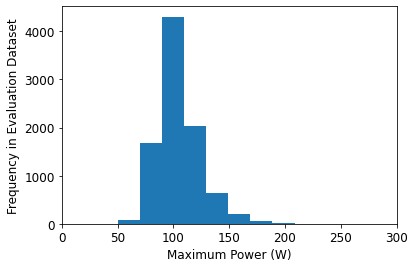

In [160]:
fig, ax = plt.subplots()
ax.hist(vmp_filtered['MPP'], color='C0')
#ax.hist(p_list, color='C1')
ax.set_xlabel('Maximum Power (W)',fontsize='large')
ax.set_ylabel('Frequency in Evaluation Dataset',fontsize='large')
ax.tick_params(axis='both', labelsize='large')
ax.set_xlim(0,300)
fig.savefig('histogram.png',dpi=300,bbox_inches="tight")

In [197]:
""" Create custom dataset """

class CustomDataset(Dataset):
    def __init__(self, df, rotate=None):
        self.df = df
        self.rotate = rotate # for rotation of shading maps?

    def __getitem__(self, index):
        shading_map = self.df.iloc[index, 0]
        shading_map = shading_series[shading_map]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        
        x = self.df.iloc[index, 1]
        x = configurations[x]
        #print(x)
        x = super_to_embedding(10, 6, x) # superstring to boolean embedding
        embedding = x.embedding
        terminal_array = x.terminal_array
        embedding = embedding.flatten()
        terminal_array = terminal_array.flatten()
        
        label = np.append(embedding, terminal_array)
        label = torch.Tensor(label)
        
        power = self.df.iloc[index, -1]
        
        return shading_map, label, power 
        
    def __len__(self):
        return len(self.df['Shading Map #'])
dataset = CustomDataset(vmp_filtered)
print(dataset.__getitem__(2))
print(dataset.__getitem__(2)[0].shape, dataset.__getitem__(2)[1].shape)


(tensor([[[0.5388, 0.4008, 0.1380, 0.0591, 0.0493, 0.0000],
         [0.9790, 0.8180, 0.3351, 0.2661, 0.2037, 0.1675],
         [1.0000, 1.0000, 0.8147, 0.6537, 0.4895, 0.3219],
         [0.9527, 1.0000, 1.0000, 1.0000, 0.8311, 0.6636],
         [0.5848, 1.0000, 1.0000, 0.9921, 1.0000, 1.0000],
         [0.3187, 1.0000, 1.0000, 0.7917, 1.0000, 1.0000],
         [0.8081, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [0.4665, 0.4731, 0.4304, 0.6833, 1.0000, 1.0000],
         [0.7753, 0.5322, 0.1938, 0.4205, 0.6439, 0.6110],
         [0.4304, 0.2661, 0.1445, 0.5519, 0.7096, 0.3942]]]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), 0.1295704230229717)
torch.Size([1, 10, 6]) torch.Size([10920])


In [216]:
""" Initialize Hyperparameters """
#10,000 iterations, batching of 32

#1e-3 learning rate

# vary each training parameter individually, run multiple experiments. Checkpoint each model, filename w/ parameters

batch_size = 24 # 32-64 is advisable
learning_rate = 5e-3 # sensitivity of gradient descent
num_epochs = 1 # iterations over entire dataset 


31121
torch.Size([10920])


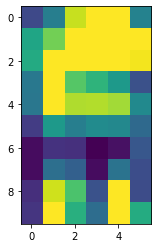

In [217]:
""" Dataloader """
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print(len(train_dataloader))
x, y, p = next(iter(train_dataloader))
img = x[0].squeeze()
embedding = y[0].squeeze()
plt.imshow(img)
print(embedding.shape)

In [218]:
model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu


In [230]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [231]:
# iterate over epochs
entropy_loss = nn.MSELoss(reduction='none')
outfile = 'loss.csv'
with open(outfile, 'w', newline='') as f:
    writer = csv.writer(f)
    for epoch in range(num_epochs):

        # iterate over training dataset by batch
        for i, data in enumerate(train_dataloader, 0):

            shading_maps, embeddings, power = data
            shading_maps = shading_maps.to(device)
            result = model(shading_maps)
            """
            result = model(shading_maps)
            for j in range(batch_size):       
                result = model(shading_maps[j,...])[-1]
                label = embeddings[j]
                loss_ += entropy_loss(result.float(), label.float())
                break
            break
            """
            loss = torch.mean(entropy_loss(result, embeddings),axis=1)
            loss = torch.mean(loss*(1-power))
            print(i, loss)
            writer.writerow([i, loss])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print('Epoch {}: Loss {}'.format(epoch, loss))

# create validation/evaluation batch of 10 or so shading maps, calculate the power from that
# visualise embeddings or circuit diagram against shading map

# use embeddings generated by superstrings for supervised approach. 
# pre-train on training_data.csv
# binary cross entropy between model and training data

# sort training_data.csv by performance (power)
# train same model by binary cross entropy
# use entire dataset, then use higher performing subset, then a subset of that, etc. 
# label = embedding

0 tensor(0.0388, dtype=torch.float64, grad_fn=<MeanBackward0>)
1 tensor(0.0280, dtype=torch.float64, grad_fn=<MeanBackward0>)
2 tensor(0.0411, dtype=torch.float64, grad_fn=<MeanBackward0>)
3 tensor(0.0456, dtype=torch.float64, grad_fn=<MeanBackward0>)
4 tensor(0.0316, dtype=torch.float64, grad_fn=<MeanBackward0>)
5 tensor(0.0483, dtype=torch.float64, grad_fn=<MeanBackward0>)
6 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
7 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
8 tensor(0.0357, dtype=torch.float64, grad_fn=<MeanBackward0>)
9 tensor(0.0492, dtype=torch.float64, grad_fn=<MeanBackward0>)
10 tensor(0.0444, dtype=torch.float64, grad_fn=<MeanBackward0>)
11 tensor(0.0277, dtype=torch.float64, grad_fn=<MeanBackward0>)
12 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
13 tensor(0.0218, dtype=torch.float64, grad_fn=<MeanBackward0>)
14 tensor(0.0266, dtype=torch.float64, grad_fn=<MeanBackward0>)
15 tensor(0.0303, dtype=torch.float64, grad_fn=<Me

128 tensor(0.0239, dtype=torch.float64, grad_fn=<MeanBackward0>)
129 tensor(0.0208, dtype=torch.float64, grad_fn=<MeanBackward0>)
130 tensor(0.0405, dtype=torch.float64, grad_fn=<MeanBackward0>)
131 tensor(0.0321, dtype=torch.float64, grad_fn=<MeanBackward0>)
132 tensor(0.0407, dtype=torch.float64, grad_fn=<MeanBackward0>)
133 tensor(0.0362, dtype=torch.float64, grad_fn=<MeanBackward0>)
134 tensor(0.0245, dtype=torch.float64, grad_fn=<MeanBackward0>)
135 tensor(0.0265, dtype=torch.float64, grad_fn=<MeanBackward0>)
136 tensor(0.0299, dtype=torch.float64, grad_fn=<MeanBackward0>)
137 tensor(0.0430, dtype=torch.float64, grad_fn=<MeanBackward0>)
138 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackward0>)
139 tensor(0.0529, dtype=torch.float64, grad_fn=<MeanBackward0>)
140 tensor(0.0232, dtype=torch.float64, grad_fn=<MeanBackward0>)
141 tensor(0.0466, dtype=torch.float64, grad_fn=<MeanBackward0>)
142 tensor(0.0454, dtype=torch.float64, grad_fn=<MeanBackward0>)
143 tensor(0.0279, dtype=

255 tensor(0.0272, dtype=torch.float64, grad_fn=<MeanBackward0>)
256 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
257 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
258 tensor(0.0190, dtype=torch.float64, grad_fn=<MeanBackward0>)
259 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
260 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
261 tensor(0.0318, dtype=torch.float64, grad_fn=<MeanBackward0>)
262 tensor(0.0429, dtype=torch.float64, grad_fn=<MeanBackward0>)
263 tensor(0.0202, dtype=torch.float64, grad_fn=<MeanBackward0>)
264 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
265 tensor(0.0432, dtype=torch.float64, grad_fn=<MeanBackward0>)
266 tensor(0.0294, dtype=torch.float64, grad_fn=<MeanBackward0>)
267 tensor(0.0203, dtype=torch.float64, grad_fn=<MeanBackward0>)
268 tensor(0.0437, dtype=torch.float64, grad_fn=<MeanBackward0>)
269 tensor(0.0235, dtype=torch.float64, grad_fn=<MeanBackward0>)
270 tensor(0.0270, dtype=

382 tensor(0.0365, dtype=torch.float64, grad_fn=<MeanBackward0>)
383 tensor(0.0402, dtype=torch.float64, grad_fn=<MeanBackward0>)
384 tensor(0.0239, dtype=torch.float64, grad_fn=<MeanBackward0>)
385 tensor(0.0301, dtype=torch.float64, grad_fn=<MeanBackward0>)
386 tensor(0.0320, dtype=torch.float64, grad_fn=<MeanBackward0>)
387 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
388 tensor(0.0420, dtype=torch.float64, grad_fn=<MeanBackward0>)
389 tensor(0.0305, dtype=torch.float64, grad_fn=<MeanBackward0>)
390 tensor(0.0196, dtype=torch.float64, grad_fn=<MeanBackward0>)
391 tensor(0.0389, dtype=torch.float64, grad_fn=<MeanBackward0>)
392 tensor(0.0415, dtype=torch.float64, grad_fn=<MeanBackward0>)
393 tensor(0.0318, dtype=torch.float64, grad_fn=<MeanBackward0>)
394 tensor(0.0312, dtype=torch.float64, grad_fn=<MeanBackward0>)
395 tensor(0.0338, dtype=torch.float64, grad_fn=<MeanBackward0>)
396 tensor(0.0375, dtype=torch.float64, grad_fn=<MeanBackward0>)
397 tensor(0.0295, dtype=

509 tensor(0.0356, dtype=torch.float64, grad_fn=<MeanBackward0>)
510 tensor(0.0273, dtype=torch.float64, grad_fn=<MeanBackward0>)
511 tensor(0.0320, dtype=torch.float64, grad_fn=<MeanBackward0>)
512 tensor(0.0202, dtype=torch.float64, grad_fn=<MeanBackward0>)
513 tensor(0.0333, dtype=torch.float64, grad_fn=<MeanBackward0>)
514 tensor(0.0351, dtype=torch.float64, grad_fn=<MeanBackward0>)
515 tensor(0.0293, dtype=torch.float64, grad_fn=<MeanBackward0>)
516 tensor(0.0263, dtype=torch.float64, grad_fn=<MeanBackward0>)
517 tensor(0.0580, dtype=torch.float64, grad_fn=<MeanBackward0>)
518 tensor(0.0266, dtype=torch.float64, grad_fn=<MeanBackward0>)
519 tensor(0.0477, dtype=torch.float64, grad_fn=<MeanBackward0>)
520 tensor(0.0389, dtype=torch.float64, grad_fn=<MeanBackward0>)
521 tensor(0.0378, dtype=torch.float64, grad_fn=<MeanBackward0>)
522 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
523 tensor(0.0210, dtype=torch.float64, grad_fn=<MeanBackward0>)
524 tensor(0.0359, dtype=

636 tensor(0.0280, dtype=torch.float64, grad_fn=<MeanBackward0>)
637 tensor(0.0372, dtype=torch.float64, grad_fn=<MeanBackward0>)
638 tensor(0.0344, dtype=torch.float64, grad_fn=<MeanBackward0>)
639 tensor(0.0312, dtype=torch.float64, grad_fn=<MeanBackward0>)
640 tensor(0.0193, dtype=torch.float64, grad_fn=<MeanBackward0>)
641 tensor(0.0571, dtype=torch.float64, grad_fn=<MeanBackward0>)
642 tensor(0.0377, dtype=torch.float64, grad_fn=<MeanBackward0>)
643 tensor(0.0301, dtype=torch.float64, grad_fn=<MeanBackward0>)
644 tensor(0.0394, dtype=torch.float64, grad_fn=<MeanBackward0>)
645 tensor(0.0404, dtype=torch.float64, grad_fn=<MeanBackward0>)
646 tensor(0.0437, dtype=torch.float64, grad_fn=<MeanBackward0>)
647 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackward0>)
648 tensor(0.0290, dtype=torch.float64, grad_fn=<MeanBackward0>)
649 tensor(0.0241, dtype=torch.float64, grad_fn=<MeanBackward0>)
650 tensor(0.0268, dtype=torch.float64, grad_fn=<MeanBackward0>)
651 tensor(0.0221, dtype=

763 tensor(0.0462, dtype=torch.float64, grad_fn=<MeanBackward0>)
764 tensor(0.0261, dtype=torch.float64, grad_fn=<MeanBackward0>)
765 tensor(0.0252, dtype=torch.float64, grad_fn=<MeanBackward0>)
766 tensor(0.0240, dtype=torch.float64, grad_fn=<MeanBackward0>)
767 tensor(0.0341, dtype=torch.float64, grad_fn=<MeanBackward0>)
768 tensor(0.0377, dtype=torch.float64, grad_fn=<MeanBackward0>)
769 tensor(0.0316, dtype=torch.float64, grad_fn=<MeanBackward0>)
770 tensor(0.0274, dtype=torch.float64, grad_fn=<MeanBackward0>)
771 tensor(0.0346, dtype=torch.float64, grad_fn=<MeanBackward0>)
772 tensor(0.0286, dtype=torch.float64, grad_fn=<MeanBackward0>)
773 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
774 tensor(0.0215, dtype=torch.float64, grad_fn=<MeanBackward0>)
775 tensor(0.0346, dtype=torch.float64, grad_fn=<MeanBackward0>)
776 tensor(0.0326, dtype=torch.float64, grad_fn=<MeanBackward0>)
777 tensor(0.0227, dtype=torch.float64, grad_fn=<MeanBackward0>)
778 tensor(0.0257, dtype=

890 tensor(0.0423, dtype=torch.float64, grad_fn=<MeanBackward0>)
891 tensor(0.0297, dtype=torch.float64, grad_fn=<MeanBackward0>)
892 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
893 tensor(0.0349, dtype=torch.float64, grad_fn=<MeanBackward0>)
894 tensor(0.0296, dtype=torch.float64, grad_fn=<MeanBackward0>)
895 tensor(0.0309, dtype=torch.float64, grad_fn=<MeanBackward0>)
896 tensor(0.0296, dtype=torch.float64, grad_fn=<MeanBackward0>)
897 tensor(0.0337, dtype=torch.float64, grad_fn=<MeanBackward0>)
898 tensor(0.0350, dtype=torch.float64, grad_fn=<MeanBackward0>)
899 tensor(0.0310, dtype=torch.float64, grad_fn=<MeanBackward0>)
900 tensor(0.0389, dtype=torch.float64, grad_fn=<MeanBackward0>)
901 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
902 tensor(0.0302, dtype=torch.float64, grad_fn=<MeanBackward0>)
903 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
904 tensor(0.0417, dtype=torch.float64, grad_fn=<MeanBackward0>)
905 tensor(0.0391, dtype=

1016 tensor(0.0338, dtype=torch.float64, grad_fn=<MeanBackward0>)
1017 tensor(0.0312, dtype=torch.float64, grad_fn=<MeanBackward0>)
1018 tensor(0.0305, dtype=torch.float64, grad_fn=<MeanBackward0>)
1019 tensor(0.0321, dtype=torch.float64, grad_fn=<MeanBackward0>)
1020 tensor(0.0231, dtype=torch.float64, grad_fn=<MeanBackward0>)
1021 tensor(0.0286, dtype=torch.float64, grad_fn=<MeanBackward0>)
1022 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
1023 tensor(0.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
1024 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
1025 tensor(0.0376, dtype=torch.float64, grad_fn=<MeanBackward0>)
1026 tensor(0.0273, dtype=torch.float64, grad_fn=<MeanBackward0>)
1027 tensor(0.0400, dtype=torch.float64, grad_fn=<MeanBackward0>)
1028 tensor(0.0368, dtype=torch.float64, grad_fn=<MeanBackward0>)
1029 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
1030 tensor(0.0397, dtype=torch.float64, grad_fn=<MeanBackward0>)
1031 tenso

1141 tensor(0.0467, dtype=torch.float64, grad_fn=<MeanBackward0>)
1142 tensor(0.0466, dtype=torch.float64, grad_fn=<MeanBackward0>)
1143 tensor(0.0280, dtype=torch.float64, grad_fn=<MeanBackward0>)
1144 tensor(0.0411, dtype=torch.float64, grad_fn=<MeanBackward0>)
1145 tensor(0.0328, dtype=torch.float64, grad_fn=<MeanBackward0>)
1146 tensor(0.0265, dtype=torch.float64, grad_fn=<MeanBackward0>)
1147 tensor(0.0285, dtype=torch.float64, grad_fn=<MeanBackward0>)
1148 tensor(0.0268, dtype=torch.float64, grad_fn=<MeanBackward0>)
1149 tensor(0.0305, dtype=torch.float64, grad_fn=<MeanBackward0>)
1150 tensor(0.0287, dtype=torch.float64, grad_fn=<MeanBackward0>)
1151 tensor(0.0344, dtype=torch.float64, grad_fn=<MeanBackward0>)
1152 tensor(0.0421, dtype=torch.float64, grad_fn=<MeanBackward0>)
1153 tensor(0.0238, dtype=torch.float64, grad_fn=<MeanBackward0>)
1154 tensor(0.0307, dtype=torch.float64, grad_fn=<MeanBackward0>)
1155 tensor(0.0261, dtype=torch.float64, grad_fn=<MeanBackward0>)
1156 tenso

1266 tensor(0.0383, dtype=torch.float64, grad_fn=<MeanBackward0>)
1267 tensor(0.0264, dtype=torch.float64, grad_fn=<MeanBackward0>)
1268 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
1269 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)
1270 tensor(0.0318, dtype=torch.float64, grad_fn=<MeanBackward0>)
1271 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
1272 tensor(0.0301, dtype=torch.float64, grad_fn=<MeanBackward0>)
1273 tensor(0.0405, dtype=torch.float64, grad_fn=<MeanBackward0>)
1274 tensor(0.0355, dtype=torch.float64, grad_fn=<MeanBackward0>)
1275 tensor(0.0349, dtype=torch.float64, grad_fn=<MeanBackward0>)
1276 tensor(0.0390, dtype=torch.float64, grad_fn=<MeanBackward0>)
1277 tensor(0.0230, dtype=torch.float64, grad_fn=<MeanBackward0>)
1278 tensor(0.0400, dtype=torch.float64, grad_fn=<MeanBackward0>)
1279 tensor(0.0221, dtype=torch.float64, grad_fn=<MeanBackward0>)
1280 tensor(0.0335, dtype=torch.float64, grad_fn=<MeanBackward0>)
1281 tenso

1391 tensor(0.0375, dtype=torch.float64, grad_fn=<MeanBackward0>)
1392 tensor(0.0191, dtype=torch.float64, grad_fn=<MeanBackward0>)
1393 tensor(0.0304, dtype=torch.float64, grad_fn=<MeanBackward0>)
1394 tensor(0.0172, dtype=torch.float64, grad_fn=<MeanBackward0>)
1395 tensor(0.0312, dtype=torch.float64, grad_fn=<MeanBackward0>)
1396 tensor(0.0444, dtype=torch.float64, grad_fn=<MeanBackward0>)
1397 tensor(0.0214, dtype=torch.float64, grad_fn=<MeanBackward0>)
1398 tensor(0.0312, dtype=torch.float64, grad_fn=<MeanBackward0>)
1399 tensor(0.0219, dtype=torch.float64, grad_fn=<MeanBackward0>)
1400 tensor(0.0506, dtype=torch.float64, grad_fn=<MeanBackward0>)
1401 tensor(0.0398, dtype=torch.float64, grad_fn=<MeanBackward0>)
1402 tensor(0.0367, dtype=torch.float64, grad_fn=<MeanBackward0>)
1403 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
1404 tensor(0.0306, dtype=torch.float64, grad_fn=<MeanBackward0>)
1405 tensor(0.0328, dtype=torch.float64, grad_fn=<MeanBackward0>)
1406 tenso

1516 tensor(0.0273, dtype=torch.float64, grad_fn=<MeanBackward0>)
1517 tensor(0.0331, dtype=torch.float64, grad_fn=<MeanBackward0>)
1518 tensor(0.0319, dtype=torch.float64, grad_fn=<MeanBackward0>)
1519 tensor(0.0387, dtype=torch.float64, grad_fn=<MeanBackward0>)
1520 tensor(0.0400, dtype=torch.float64, grad_fn=<MeanBackward0>)
1521 tensor(0.0337, dtype=torch.float64, grad_fn=<MeanBackward0>)
1522 tensor(0.0367, dtype=torch.float64, grad_fn=<MeanBackward0>)
1523 tensor(0.0251, dtype=torch.float64, grad_fn=<MeanBackward0>)
1524 tensor(0.0301, dtype=torch.float64, grad_fn=<MeanBackward0>)
1525 tensor(0.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
1526 tensor(0.0329, dtype=torch.float64, grad_fn=<MeanBackward0>)
1527 tensor(0.0245, dtype=torch.float64, grad_fn=<MeanBackward0>)
1528 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
1529 tensor(0.0277, dtype=torch.float64, grad_fn=<MeanBackward0>)
1530 tensor(0.0351, dtype=torch.float64, grad_fn=<MeanBackward0>)
1531 tenso

1641 tensor(0.0391, dtype=torch.float64, grad_fn=<MeanBackward0>)
1642 tensor(0.0310, dtype=torch.float64, grad_fn=<MeanBackward0>)
1643 tensor(0.0323, dtype=torch.float64, grad_fn=<MeanBackward0>)
1644 tensor(0.0289, dtype=torch.float64, grad_fn=<MeanBackward0>)
1645 tensor(0.0334, dtype=torch.float64, grad_fn=<MeanBackward0>)
1646 tensor(0.0179, dtype=torch.float64, grad_fn=<MeanBackward0>)
1647 tensor(0.0210, dtype=torch.float64, grad_fn=<MeanBackward0>)
1648 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
1649 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
1650 tensor(0.0363, dtype=torch.float64, grad_fn=<MeanBackward0>)
1651 tensor(0.0240, dtype=torch.float64, grad_fn=<MeanBackward0>)
1652 tensor(0.0250, dtype=torch.float64, grad_fn=<MeanBackward0>)
1653 tensor(0.0350, dtype=torch.float64, grad_fn=<MeanBackward0>)
1654 tensor(0.0340, dtype=torch.float64, grad_fn=<MeanBackward0>)
1655 tensor(0.0185, dtype=torch.float64, grad_fn=<MeanBackward0>)
1656 tenso

1766 tensor(0.0223, dtype=torch.float64, grad_fn=<MeanBackward0>)
1767 tensor(0.0333, dtype=torch.float64, grad_fn=<MeanBackward0>)
1768 tensor(0.0231, dtype=torch.float64, grad_fn=<MeanBackward0>)
1769 tensor(0.0383, dtype=torch.float64, grad_fn=<MeanBackward0>)
1770 tensor(0.0279, dtype=torch.float64, grad_fn=<MeanBackward0>)
1771 tensor(0.0359, dtype=torch.float64, grad_fn=<MeanBackward0>)
1772 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
1773 tensor(0.0480, dtype=torch.float64, grad_fn=<MeanBackward0>)
1774 tensor(0.0379, dtype=torch.float64, grad_fn=<MeanBackward0>)
1775 tensor(0.0365, dtype=torch.float64, grad_fn=<MeanBackward0>)
1776 tensor(0.0306, dtype=torch.float64, grad_fn=<MeanBackward0>)
1777 tensor(0.0274, dtype=torch.float64, grad_fn=<MeanBackward0>)
1778 tensor(0.0264, dtype=torch.float64, grad_fn=<MeanBackward0>)
1779 tensor(0.0280, dtype=torch.float64, grad_fn=<MeanBackward0>)
1780 tensor(0.0387, dtype=torch.float64, grad_fn=<MeanBackward0>)
1781 tenso

1891 tensor(0.0204, dtype=torch.float64, grad_fn=<MeanBackward0>)
1892 tensor(0.0245, dtype=torch.float64, grad_fn=<MeanBackward0>)
1893 tensor(0.0349, dtype=torch.float64, grad_fn=<MeanBackward0>)
1894 tensor(0.0235, dtype=torch.float64, grad_fn=<MeanBackward0>)
1895 tensor(0.0279, dtype=torch.float64, grad_fn=<MeanBackward0>)
1896 tensor(0.0233, dtype=torch.float64, grad_fn=<MeanBackward0>)
1897 tensor(0.0380, dtype=torch.float64, grad_fn=<MeanBackward0>)
1898 tensor(0.0401, dtype=torch.float64, grad_fn=<MeanBackward0>)
1899 tensor(0.0344, dtype=torch.float64, grad_fn=<MeanBackward0>)
1900 tensor(0.0305, dtype=torch.float64, grad_fn=<MeanBackward0>)
1901 tensor(0.0183, dtype=torch.float64, grad_fn=<MeanBackward0>)
1902 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
1903 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
1904 tensor(0.0197, dtype=torch.float64, grad_fn=<MeanBackward0>)
1905 tensor(0.0401, dtype=torch.float64, grad_fn=<MeanBackward0>)
1906 tenso

2016 tensor(0.0414, dtype=torch.float64, grad_fn=<MeanBackward0>)
2017 tensor(0.0371, dtype=torch.float64, grad_fn=<MeanBackward0>)
2018 tensor(0.0215, dtype=torch.float64, grad_fn=<MeanBackward0>)
2019 tensor(0.0475, dtype=torch.float64, grad_fn=<MeanBackward0>)
2020 tensor(0.0294, dtype=torch.float64, grad_fn=<MeanBackward0>)
2021 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
2022 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
2023 tensor(0.0206, dtype=torch.float64, grad_fn=<MeanBackward0>)
2024 tensor(0.0477, dtype=torch.float64, grad_fn=<MeanBackward0>)
2025 tensor(0.0278, dtype=torch.float64, grad_fn=<MeanBackward0>)
2026 tensor(0.0326, dtype=torch.float64, grad_fn=<MeanBackward0>)
2027 tensor(0.0243, dtype=torch.float64, grad_fn=<MeanBackward0>)
2028 tensor(0.0291, dtype=torch.float64, grad_fn=<MeanBackward0>)
2029 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
2030 tensor(0.0399, dtype=torch.float64, grad_fn=<MeanBackward0>)
2031 tenso

2141 tensor(0.0232, dtype=torch.float64, grad_fn=<MeanBackward0>)
2142 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
2143 tensor(0.0320, dtype=torch.float64, grad_fn=<MeanBackward0>)
2144 tensor(0.0322, dtype=torch.float64, grad_fn=<MeanBackward0>)
2145 tensor(0.0312, dtype=torch.float64, grad_fn=<MeanBackward0>)
2146 tensor(0.0252, dtype=torch.float64, grad_fn=<MeanBackward0>)
2147 tensor(0.0285, dtype=torch.float64, grad_fn=<MeanBackward0>)
2148 tensor(0.0343, dtype=torch.float64, grad_fn=<MeanBackward0>)
2149 tensor(0.0367, dtype=torch.float64, grad_fn=<MeanBackward0>)
2150 tensor(0.0322, dtype=torch.float64, grad_fn=<MeanBackward0>)
2151 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
2152 tensor(0.0293, dtype=torch.float64, grad_fn=<MeanBackward0>)
2153 tensor(0.0407, dtype=torch.float64, grad_fn=<MeanBackward0>)
2154 tensor(0.0449, dtype=torch.float64, grad_fn=<MeanBackward0>)
2155 tensor(0.0361, dtype=torch.float64, grad_fn=<MeanBackward0>)
2156 tenso

2266 tensor(0.0349, dtype=torch.float64, grad_fn=<MeanBackward0>)
2267 tensor(0.0272, dtype=torch.float64, grad_fn=<MeanBackward0>)
2268 tensor(0.0300, dtype=torch.float64, grad_fn=<MeanBackward0>)
2269 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
2270 tensor(0.0489, dtype=torch.float64, grad_fn=<MeanBackward0>)
2271 tensor(0.0234, dtype=torch.float64, grad_fn=<MeanBackward0>)
2272 tensor(0.0435, dtype=torch.float64, grad_fn=<MeanBackward0>)
2273 tensor(0.0513, dtype=torch.float64, grad_fn=<MeanBackward0>)
2274 tensor(0.0327, dtype=torch.float64, grad_fn=<MeanBackward0>)
2275 tensor(0.0442, dtype=torch.float64, grad_fn=<MeanBackward0>)
2276 tensor(0.0325, dtype=torch.float64, grad_fn=<MeanBackward0>)
2277 tensor(0.0237, dtype=torch.float64, grad_fn=<MeanBackward0>)
2278 tensor(0.0243, dtype=torch.float64, grad_fn=<MeanBackward0>)
2279 tensor(0.0267, dtype=torch.float64, grad_fn=<MeanBackward0>)
2280 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
2281 tenso

2391 tensor(0.0356, dtype=torch.float64, grad_fn=<MeanBackward0>)
2392 tensor(0.0307, dtype=torch.float64, grad_fn=<MeanBackward0>)
2393 tensor(0.0327, dtype=torch.float64, grad_fn=<MeanBackward0>)
2394 tensor(0.0375, dtype=torch.float64, grad_fn=<MeanBackward0>)
2395 tensor(0.0235, dtype=torch.float64, grad_fn=<MeanBackward0>)
2396 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
2397 tensor(0.0545, dtype=torch.float64, grad_fn=<MeanBackward0>)
2398 tensor(0.0265, dtype=torch.float64, grad_fn=<MeanBackward0>)
2399 tensor(0.0241, dtype=torch.float64, grad_fn=<MeanBackward0>)
2400 tensor(0.0417, dtype=torch.float64, grad_fn=<MeanBackward0>)
2401 tensor(0.0416, dtype=torch.float64, grad_fn=<MeanBackward0>)
2402 tensor(0.0456, dtype=torch.float64, grad_fn=<MeanBackward0>)
2403 tensor(0.0241, dtype=torch.float64, grad_fn=<MeanBackward0>)
2404 tensor(0.0246, dtype=torch.float64, grad_fn=<MeanBackward0>)
2405 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackward0>)
2406 tenso

2516 tensor(0.0256, dtype=torch.float64, grad_fn=<MeanBackward0>)
2517 tensor(0.0175, dtype=torch.float64, grad_fn=<MeanBackward0>)
2518 tensor(0.0239, dtype=torch.float64, grad_fn=<MeanBackward0>)
2519 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
2520 tensor(0.0286, dtype=torch.float64, grad_fn=<MeanBackward0>)
2521 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
2522 tensor(0.0252, dtype=torch.float64, grad_fn=<MeanBackward0>)
2523 tensor(0.0389, dtype=torch.float64, grad_fn=<MeanBackward0>)
2524 tensor(0.0273, dtype=torch.float64, grad_fn=<MeanBackward0>)
2525 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
2526 tensor(0.0209, dtype=torch.float64, grad_fn=<MeanBackward0>)
2527 tensor(0.0253, dtype=torch.float64, grad_fn=<MeanBackward0>)
2528 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
2529 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
2530 tensor(0.0214, dtype=torch.float64, grad_fn=<MeanBackward0>)
2531 tenso

2641 tensor(0.0322, dtype=torch.float64, grad_fn=<MeanBackward0>)
2642 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
2643 tensor(0.0213, dtype=torch.float64, grad_fn=<MeanBackward0>)
2644 tensor(0.0350, dtype=torch.float64, grad_fn=<MeanBackward0>)
2645 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
2646 tensor(0.0417, dtype=torch.float64, grad_fn=<MeanBackward0>)
2647 tensor(0.0244, dtype=torch.float64, grad_fn=<MeanBackward0>)
2648 tensor(0.0227, dtype=torch.float64, grad_fn=<MeanBackward0>)
2649 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
2650 tensor(0.0305, dtype=torch.float64, grad_fn=<MeanBackward0>)
2651 tensor(0.0352, dtype=torch.float64, grad_fn=<MeanBackward0>)
2652 tensor(0.0415, dtype=torch.float64, grad_fn=<MeanBackward0>)
2653 tensor(0.0420, dtype=torch.float64, grad_fn=<MeanBackward0>)
2654 tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
2655 tensor(0.0426, dtype=torch.float64, grad_fn=<MeanBackward0>)
2656 tenso

2766 tensor(0.0492, dtype=torch.float64, grad_fn=<MeanBackward0>)
2767 tensor(0.0346, dtype=torch.float64, grad_fn=<MeanBackward0>)
2768 tensor(0.0237, dtype=torch.float64, grad_fn=<MeanBackward0>)
2769 tensor(0.0378, dtype=torch.float64, grad_fn=<MeanBackward0>)
2770 tensor(0.0326, dtype=torch.float64, grad_fn=<MeanBackward0>)
2771 tensor(0.0372, dtype=torch.float64, grad_fn=<MeanBackward0>)
2772 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
2773 tensor(0.0387, dtype=torch.float64, grad_fn=<MeanBackward0>)
2774 tensor(0.0241, dtype=torch.float64, grad_fn=<MeanBackward0>)
2775 tensor(0.0233, dtype=torch.float64, grad_fn=<MeanBackward0>)
2776 tensor(0.0445, dtype=torch.float64, grad_fn=<MeanBackward0>)
2777 tensor(0.0234, dtype=torch.float64, grad_fn=<MeanBackward0>)
2778 tensor(0.0450, dtype=torch.float64, grad_fn=<MeanBackward0>)
2779 tensor(0.0310, dtype=torch.float64, grad_fn=<MeanBackward0>)
2780 tensor(0.0199, dtype=torch.float64, grad_fn=<MeanBackward0>)
2781 tenso

2891 tensor(0.0416, dtype=torch.float64, grad_fn=<MeanBackward0>)
2892 tensor(0.0302, dtype=torch.float64, grad_fn=<MeanBackward0>)
2893 tensor(0.0234, dtype=torch.float64, grad_fn=<MeanBackward0>)
2894 tensor(0.0297, dtype=torch.float64, grad_fn=<MeanBackward0>)
2895 tensor(0.0280, dtype=torch.float64, grad_fn=<MeanBackward0>)
2896 tensor(0.0218, dtype=torch.float64, grad_fn=<MeanBackward0>)
2897 tensor(0.0236, dtype=torch.float64, grad_fn=<MeanBackward0>)
2898 tensor(0.0425, dtype=torch.float64, grad_fn=<MeanBackward0>)
2899 tensor(0.0327, dtype=torch.float64, grad_fn=<MeanBackward0>)
2900 tensor(0.0368, dtype=torch.float64, grad_fn=<MeanBackward0>)
2901 tensor(0.0220, dtype=torch.float64, grad_fn=<MeanBackward0>)
2902 tensor(0.0271, dtype=torch.float64, grad_fn=<MeanBackward0>)
2903 tensor(0.0237, dtype=torch.float64, grad_fn=<MeanBackward0>)
2904 tensor(0.0294, dtype=torch.float64, grad_fn=<MeanBackward0>)
2905 tensor(0.0341, dtype=torch.float64, grad_fn=<MeanBackward0>)
2906 tenso

3016 tensor(0.0391, dtype=torch.float64, grad_fn=<MeanBackward0>)
3017 tensor(0.0261, dtype=torch.float64, grad_fn=<MeanBackward0>)
3018 tensor(0.0338, dtype=torch.float64, grad_fn=<MeanBackward0>)
3019 tensor(0.0219, dtype=torch.float64, grad_fn=<MeanBackward0>)
3020 tensor(0.0199, dtype=torch.float64, grad_fn=<MeanBackward0>)
3021 tensor(0.0218, dtype=torch.float64, grad_fn=<MeanBackward0>)
3022 tensor(0.0435, dtype=torch.float64, grad_fn=<MeanBackward0>)
3023 tensor(0.0299, dtype=torch.float64, grad_fn=<MeanBackward0>)
3024 tensor(0.0397, dtype=torch.float64, grad_fn=<MeanBackward0>)
3025 tensor(0.0263, dtype=torch.float64, grad_fn=<MeanBackward0>)
3026 tensor(0.0291, dtype=torch.float64, grad_fn=<MeanBackward0>)
3027 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
3028 tensor(0.0279, dtype=torch.float64, grad_fn=<MeanBackward0>)
3029 tensor(0.0360, dtype=torch.float64, grad_fn=<MeanBackward0>)
3030 tensor(0.0229, dtype=torch.float64, grad_fn=<MeanBackward0>)
3031 tenso

3141 tensor(0.0329, dtype=torch.float64, grad_fn=<MeanBackward0>)
3142 tensor(0.0391, dtype=torch.float64, grad_fn=<MeanBackward0>)
3143 tensor(0.0270, dtype=torch.float64, grad_fn=<MeanBackward0>)
3144 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
3145 tensor(0.0238, dtype=torch.float64, grad_fn=<MeanBackward0>)
3146 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
3147 tensor(0.0307, dtype=torch.float64, grad_fn=<MeanBackward0>)
3148 tensor(0.0346, dtype=torch.float64, grad_fn=<MeanBackward0>)
3149 tensor(0.0419, dtype=torch.float64, grad_fn=<MeanBackward0>)
3150 tensor(0.0406, dtype=torch.float64, grad_fn=<MeanBackward0>)
3151 tensor(0.0304, dtype=torch.float64, grad_fn=<MeanBackward0>)
3152 tensor(0.0455, dtype=torch.float64, grad_fn=<MeanBackward0>)
3153 tensor(0.0251, dtype=torch.float64, grad_fn=<MeanBackward0>)
3154 tensor(0.0263, dtype=torch.float64, grad_fn=<MeanBackward0>)
3155 tensor(0.0333, dtype=torch.float64, grad_fn=<MeanBackward0>)
3156 tenso

3266 tensor(0.0230, dtype=torch.float64, grad_fn=<MeanBackward0>)
3267 tensor(0.0249, dtype=torch.float64, grad_fn=<MeanBackward0>)
3268 tensor(0.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
3269 tensor(0.0245, dtype=torch.float64, grad_fn=<MeanBackward0>)
3270 tensor(0.0264, dtype=torch.float64, grad_fn=<MeanBackward0>)
3271 tensor(0.0427, dtype=torch.float64, grad_fn=<MeanBackward0>)
3272 tensor(0.0237, dtype=torch.float64, grad_fn=<MeanBackward0>)
3273 tensor(0.0248, dtype=torch.float64, grad_fn=<MeanBackward0>)
3274 tensor(0.0484, dtype=torch.float64, grad_fn=<MeanBackward0>)
3275 tensor(0.0374, dtype=torch.float64, grad_fn=<MeanBackward0>)
3276 tensor(0.0376, dtype=torch.float64, grad_fn=<MeanBackward0>)
3277 tensor(0.0405, dtype=torch.float64, grad_fn=<MeanBackward0>)
3278 tensor(0.0340, dtype=torch.float64, grad_fn=<MeanBackward0>)
3279 tensor(0.0271, dtype=torch.float64, grad_fn=<MeanBackward0>)
3280 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
3281 tenso

3391 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
3392 tensor(0.0368, dtype=torch.float64, grad_fn=<MeanBackward0>)
3393 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
3394 tensor(0.0299, dtype=torch.float64, grad_fn=<MeanBackward0>)
3395 tensor(0.0246, dtype=torch.float64, grad_fn=<MeanBackward0>)
3396 tensor(0.0365, dtype=torch.float64, grad_fn=<MeanBackward0>)
3397 tensor(0.0345, dtype=torch.float64, grad_fn=<MeanBackward0>)
3398 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
3399 tensor(0.0379, dtype=torch.float64, grad_fn=<MeanBackward0>)
3400 tensor(0.0362, dtype=torch.float64, grad_fn=<MeanBackward0>)
3401 tensor(0.0420, dtype=torch.float64, grad_fn=<MeanBackward0>)
3402 tensor(0.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
3403 tensor(0.0343, dtype=torch.float64, grad_fn=<MeanBackward0>)
3404 tensor(0.0204, dtype=torch.float64, grad_fn=<MeanBackward0>)
3405 tensor(0.0295, dtype=torch.float64, grad_fn=<MeanBackward0>)
3406 tenso

3516 tensor(0.0287, dtype=torch.float64, grad_fn=<MeanBackward0>)
3517 tensor(0.0171, dtype=torch.float64, grad_fn=<MeanBackward0>)
3518 tensor(0.0367, dtype=torch.float64, grad_fn=<MeanBackward0>)
3519 tensor(0.0243, dtype=torch.float64, grad_fn=<MeanBackward0>)
3520 tensor(0.0230, dtype=torch.float64, grad_fn=<MeanBackward0>)
3521 tensor(0.0235, dtype=torch.float64, grad_fn=<MeanBackward0>)
3522 tensor(0.0298, dtype=torch.float64, grad_fn=<MeanBackward0>)
3523 tensor(0.0279, dtype=torch.float64, grad_fn=<MeanBackward0>)
3524 tensor(0.0340, dtype=torch.float64, grad_fn=<MeanBackward0>)
3525 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
3526 tensor(0.0319, dtype=torch.float64, grad_fn=<MeanBackward0>)
3527 tensor(0.0367, dtype=torch.float64, grad_fn=<MeanBackward0>)
3528 tensor(0.0256, dtype=torch.float64, grad_fn=<MeanBackward0>)
3529 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
3530 tensor(0.0385, dtype=torch.float64, grad_fn=<MeanBackward0>)
3531 tenso

3641 tensor(0.0478, dtype=torch.float64, grad_fn=<MeanBackward0>)
3642 tensor(0.0325, dtype=torch.float64, grad_fn=<MeanBackward0>)
3643 tensor(0.0375, dtype=torch.float64, grad_fn=<MeanBackward0>)
3644 tensor(0.0394, dtype=torch.float64, grad_fn=<MeanBackward0>)
3645 tensor(0.0357, dtype=torch.float64, grad_fn=<MeanBackward0>)
3646 tensor(0.0347, dtype=torch.float64, grad_fn=<MeanBackward0>)
3647 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
3648 tensor(0.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
3649 tensor(0.0354, dtype=torch.float64, grad_fn=<MeanBackward0>)
3650 tensor(0.0385, dtype=torch.float64, grad_fn=<MeanBackward0>)
3651 tensor(0.0334, dtype=torch.float64, grad_fn=<MeanBackward0>)
3652 tensor(0.0231, dtype=torch.float64, grad_fn=<MeanBackward0>)
3653 tensor(0.0395, dtype=torch.float64, grad_fn=<MeanBackward0>)
3654 tensor(0.0275, dtype=torch.float64, grad_fn=<MeanBackward0>)
3655 tensor(0.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
3656 tenso

3766 tensor(0.0386, dtype=torch.float64, grad_fn=<MeanBackward0>)
3767 tensor(0.0283, dtype=torch.float64, grad_fn=<MeanBackward0>)
3768 tensor(0.0392, dtype=torch.float64, grad_fn=<MeanBackward0>)
3769 tensor(0.0370, dtype=torch.float64, grad_fn=<MeanBackward0>)
3770 tensor(0.0236, dtype=torch.float64, grad_fn=<MeanBackward0>)
3771 tensor(0.0286, dtype=torch.float64, grad_fn=<MeanBackward0>)
3772 tensor(0.0222, dtype=torch.float64, grad_fn=<MeanBackward0>)
3773 tensor(0.0326, dtype=torch.float64, grad_fn=<MeanBackward0>)
3774 tensor(0.0321, dtype=torch.float64, grad_fn=<MeanBackward0>)
3775 tensor(0.0368, dtype=torch.float64, grad_fn=<MeanBackward0>)
3776 tensor(0.0255, dtype=torch.float64, grad_fn=<MeanBackward0>)
3777 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
3778 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
3779 tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
3780 tensor(0.0347, dtype=torch.float64, grad_fn=<MeanBackward0>)
3781 tenso

3891 tensor(0.0494, dtype=torch.float64, grad_fn=<MeanBackward0>)
3892 tensor(0.0234, dtype=torch.float64, grad_fn=<MeanBackward0>)
3893 tensor(0.0290, dtype=torch.float64, grad_fn=<MeanBackward0>)
3894 tensor(0.0385, dtype=torch.float64, grad_fn=<MeanBackward0>)
3895 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
3896 tensor(0.0408, dtype=torch.float64, grad_fn=<MeanBackward0>)
3897 tensor(0.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
3898 tensor(0.0246, dtype=torch.float64, grad_fn=<MeanBackward0>)
3899 tensor(0.0394, dtype=torch.float64, grad_fn=<MeanBackward0>)
3900 tensor(0.0239, dtype=torch.float64, grad_fn=<MeanBackward0>)
3901 tensor(0.0350, dtype=torch.float64, grad_fn=<MeanBackward0>)
3902 tensor(0.0305, dtype=torch.float64, grad_fn=<MeanBackward0>)
3903 tensor(0.0360, dtype=torch.float64, grad_fn=<MeanBackward0>)
3904 tensor(0.0394, dtype=torch.float64, grad_fn=<MeanBackward0>)
3905 tensor(0.0240, dtype=torch.float64, grad_fn=<MeanBackward0>)
3906 tenso

4016 tensor(0.0370, dtype=torch.float64, grad_fn=<MeanBackward0>)
4017 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackward0>)
4018 tensor(0.0345, dtype=torch.float64, grad_fn=<MeanBackward0>)
4019 tensor(0.0304, dtype=torch.float64, grad_fn=<MeanBackward0>)
4020 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)
4021 tensor(0.0389, dtype=torch.float64, grad_fn=<MeanBackward0>)
4022 tensor(0.0271, dtype=torch.float64, grad_fn=<MeanBackward0>)
4023 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
4024 tensor(0.0338, dtype=torch.float64, grad_fn=<MeanBackward0>)
4025 tensor(0.0474, dtype=torch.float64, grad_fn=<MeanBackward0>)
4026 tensor(0.0285, dtype=torch.float64, grad_fn=<MeanBackward0>)
4027 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
4028 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
4029 tensor(0.0258, dtype=torch.float64, grad_fn=<MeanBackward0>)
4030 tensor(0.0304, dtype=torch.float64, grad_fn=<MeanBackward0>)
4031 tenso

4141 tensor(0.0329, dtype=torch.float64, grad_fn=<MeanBackward0>)
4142 tensor(0.0329, dtype=torch.float64, grad_fn=<MeanBackward0>)
4143 tensor(0.0238, dtype=torch.float64, grad_fn=<MeanBackward0>)
4144 tensor(0.0243, dtype=torch.float64, grad_fn=<MeanBackward0>)
4145 tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
4146 tensor(0.0367, dtype=torch.float64, grad_fn=<MeanBackward0>)
4147 tensor(0.0163, dtype=torch.float64, grad_fn=<MeanBackward0>)
4148 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)
4149 tensor(0.0343, dtype=torch.float64, grad_fn=<MeanBackward0>)
4150 tensor(0.0290, dtype=torch.float64, grad_fn=<MeanBackward0>)
4151 tensor(0.0372, dtype=torch.float64, grad_fn=<MeanBackward0>)
4152 tensor(0.0350, dtype=torch.float64, grad_fn=<MeanBackward0>)
4153 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
4154 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
4155 tensor(0.0261, dtype=torch.float64, grad_fn=<MeanBackward0>)
4156 tenso

4266 tensor(0.0297, dtype=torch.float64, grad_fn=<MeanBackward0>)
4267 tensor(0.0195, dtype=torch.float64, grad_fn=<MeanBackward0>)
4268 tensor(0.0302, dtype=torch.float64, grad_fn=<MeanBackward0>)
4269 tensor(0.0359, dtype=torch.float64, grad_fn=<MeanBackward0>)
4270 tensor(0.0494, dtype=torch.float64, grad_fn=<MeanBackward0>)
4271 tensor(0.0216, dtype=torch.float64, grad_fn=<MeanBackward0>)
4272 tensor(0.0225, dtype=torch.float64, grad_fn=<MeanBackward0>)
4273 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)
4274 tensor(0.0391, dtype=torch.float64, grad_fn=<MeanBackward0>)
4275 tensor(0.0270, dtype=torch.float64, grad_fn=<MeanBackward0>)
4276 tensor(0.0251, dtype=torch.float64, grad_fn=<MeanBackward0>)
4277 tensor(0.0274, dtype=torch.float64, grad_fn=<MeanBackward0>)
4278 tensor(0.0327, dtype=torch.float64, grad_fn=<MeanBackward0>)
4279 tensor(0.0362, dtype=torch.float64, grad_fn=<MeanBackward0>)
4280 tensor(0.0365, dtype=torch.float64, grad_fn=<MeanBackward0>)
4281 tenso

4391 tensor(0.0459, dtype=torch.float64, grad_fn=<MeanBackward0>)
4392 tensor(0.0248, dtype=torch.float64, grad_fn=<MeanBackward0>)
4393 tensor(0.0408, dtype=torch.float64, grad_fn=<MeanBackward0>)
4394 tensor(0.0261, dtype=torch.float64, grad_fn=<MeanBackward0>)
4395 tensor(0.0291, dtype=torch.float64, grad_fn=<MeanBackward0>)
4396 tensor(0.0517, dtype=torch.float64, grad_fn=<MeanBackward0>)
4397 tensor(0.0247, dtype=torch.float64, grad_fn=<MeanBackward0>)
4398 tensor(0.0233, dtype=torch.float64, grad_fn=<MeanBackward0>)
4399 tensor(0.0180, dtype=torch.float64, grad_fn=<MeanBackward0>)
4400 tensor(0.0320, dtype=torch.float64, grad_fn=<MeanBackward0>)
4401 tensor(0.0388, dtype=torch.float64, grad_fn=<MeanBackward0>)
4402 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackward0>)
4403 tensor(0.0508, dtype=torch.float64, grad_fn=<MeanBackward0>)
4404 tensor(0.0433, dtype=torch.float64, grad_fn=<MeanBackward0>)
4405 tensor(0.0296, dtype=torch.float64, grad_fn=<MeanBackward0>)
4406 tenso

4516 tensor(0.0318, dtype=torch.float64, grad_fn=<MeanBackward0>)
4517 tensor(0.0434, dtype=torch.float64, grad_fn=<MeanBackward0>)
4518 tensor(0.0284, dtype=torch.float64, grad_fn=<MeanBackward0>)
4519 tensor(0.0422, dtype=torch.float64, grad_fn=<MeanBackward0>)
4520 tensor(0.0422, dtype=torch.float64, grad_fn=<MeanBackward0>)
4521 tensor(0.0407, dtype=torch.float64, grad_fn=<MeanBackward0>)
4522 tensor(0.0424, dtype=torch.float64, grad_fn=<MeanBackward0>)
4523 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
4524 tensor(0.0193, dtype=torch.float64, grad_fn=<MeanBackward0>)
4525 tensor(0.0241, dtype=torch.float64, grad_fn=<MeanBackward0>)
4526 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
4527 tensor(0.0246, dtype=torch.float64, grad_fn=<MeanBackward0>)
4528 tensor(0.0365, dtype=torch.float64, grad_fn=<MeanBackward0>)
4529 tensor(0.0195, dtype=torch.float64, grad_fn=<MeanBackward0>)
4530 tensor(0.0378, dtype=torch.float64, grad_fn=<MeanBackward0>)
4531 tenso

4641 tensor(0.0446, dtype=torch.float64, grad_fn=<MeanBackward0>)
4642 tensor(0.0240, dtype=torch.float64, grad_fn=<MeanBackward0>)
4643 tensor(0.0244, dtype=torch.float64, grad_fn=<MeanBackward0>)
4644 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
4645 tensor(0.0377, dtype=torch.float64, grad_fn=<MeanBackward0>)
4646 tensor(0.0405, dtype=torch.float64, grad_fn=<MeanBackward0>)
4647 tensor(0.0218, dtype=torch.float64, grad_fn=<MeanBackward0>)
4648 tensor(0.0327, dtype=torch.float64, grad_fn=<MeanBackward0>)
4649 tensor(0.0422, dtype=torch.float64, grad_fn=<MeanBackward0>)
4650 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
4651 tensor(0.0331, dtype=torch.float64, grad_fn=<MeanBackward0>)
4652 tensor(0.0358, dtype=torch.float64, grad_fn=<MeanBackward0>)
4653 tensor(0.0205, dtype=torch.float64, grad_fn=<MeanBackward0>)
4654 tensor(0.0329, dtype=torch.float64, grad_fn=<MeanBackward0>)
4655 tensor(0.0390, dtype=torch.float64, grad_fn=<MeanBackward0>)
4656 tenso

4766 tensor(0.0302, dtype=torch.float64, grad_fn=<MeanBackward0>)
4767 tensor(0.0407, dtype=torch.float64, grad_fn=<MeanBackward0>)
4768 tensor(0.0338, dtype=torch.float64, grad_fn=<MeanBackward0>)
4769 tensor(0.0271, dtype=torch.float64, grad_fn=<MeanBackward0>)
4770 tensor(0.0331, dtype=torch.float64, grad_fn=<MeanBackward0>)
4771 tensor(0.0263, dtype=torch.float64, grad_fn=<MeanBackward0>)
4772 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
4773 tensor(0.0518, dtype=torch.float64, grad_fn=<MeanBackward0>)
4774 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
4775 tensor(0.0200, dtype=torch.float64, grad_fn=<MeanBackward0>)
4776 tensor(0.0543, dtype=torch.float64, grad_fn=<MeanBackward0>)
4777 tensor(0.0401, dtype=torch.float64, grad_fn=<MeanBackward0>)
4778 tensor(0.0244, dtype=torch.float64, grad_fn=<MeanBackward0>)
4779 tensor(0.0328, dtype=torch.float64, grad_fn=<MeanBackward0>)
4780 tensor(0.0289, dtype=torch.float64, grad_fn=<MeanBackward0>)
4781 tenso

4891 tensor(0.0382, dtype=torch.float64, grad_fn=<MeanBackward0>)
4892 tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
4893 tensor(0.0426, dtype=torch.float64, grad_fn=<MeanBackward0>)
4894 tensor(0.0268, dtype=torch.float64, grad_fn=<MeanBackward0>)
4895 tensor(0.0389, dtype=torch.float64, grad_fn=<MeanBackward0>)
4896 tensor(0.0302, dtype=torch.float64, grad_fn=<MeanBackward0>)
4897 tensor(0.0433, dtype=torch.float64, grad_fn=<MeanBackward0>)
4898 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)
4899 tensor(0.0577, dtype=torch.float64, grad_fn=<MeanBackward0>)
4900 tensor(0.0474, dtype=torch.float64, grad_fn=<MeanBackward0>)
4901 tensor(0.0437, dtype=torch.float64, grad_fn=<MeanBackward0>)
4902 tensor(0.0358, dtype=torch.float64, grad_fn=<MeanBackward0>)
4903 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
4904 tensor(0.0163, dtype=torch.float64, grad_fn=<MeanBackward0>)
4905 tensor(0.0355, dtype=torch.float64, grad_fn=<MeanBackward0>)
4906 tenso

5016 tensor(0.0345, dtype=torch.float64, grad_fn=<MeanBackward0>)
5017 tensor(0.0396, dtype=torch.float64, grad_fn=<MeanBackward0>)
5018 tensor(0.0421, dtype=torch.float64, grad_fn=<MeanBackward0>)
5019 tensor(0.0194, dtype=torch.float64, grad_fn=<MeanBackward0>)
5020 tensor(0.0341, dtype=torch.float64, grad_fn=<MeanBackward0>)
5021 tensor(0.0228, dtype=torch.float64, grad_fn=<MeanBackward0>)
5022 tensor(0.0316, dtype=torch.float64, grad_fn=<MeanBackward0>)
5023 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackward0>)
5024 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
5025 tensor(0.0408, dtype=torch.float64, grad_fn=<MeanBackward0>)
5026 tensor(0.0358, dtype=torch.float64, grad_fn=<MeanBackward0>)
5027 tensor(0.0241, dtype=torch.float64, grad_fn=<MeanBackward0>)
5028 tensor(0.0391, dtype=torch.float64, grad_fn=<MeanBackward0>)
5029 tensor(0.0273, dtype=torch.float64, grad_fn=<MeanBackward0>)
5030 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
5031 tenso

5141 tensor(0.0438, dtype=torch.float64, grad_fn=<MeanBackward0>)
5142 tensor(0.0406, dtype=torch.float64, grad_fn=<MeanBackward0>)
5143 tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
5144 tensor(0.0289, dtype=torch.float64, grad_fn=<MeanBackward0>)
5145 tensor(0.0297, dtype=torch.float64, grad_fn=<MeanBackward0>)
5146 tensor(0.0187, dtype=torch.float64, grad_fn=<MeanBackward0>)
5147 tensor(0.0320, dtype=torch.float64, grad_fn=<MeanBackward0>)
5148 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
5149 tensor(0.0297, dtype=torch.float64, grad_fn=<MeanBackward0>)
5150 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
5151 tensor(0.0288, dtype=torch.float64, grad_fn=<MeanBackward0>)
5152 tensor(0.0399, dtype=torch.float64, grad_fn=<MeanBackward0>)
5153 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
5154 tensor(0.0401, dtype=torch.float64, grad_fn=<MeanBackward0>)
5155 tensor(0.0386, dtype=torch.float64, grad_fn=<MeanBackward0>)
5156 tenso

5266 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
5267 tensor(0.0407, dtype=torch.float64, grad_fn=<MeanBackward0>)
5268 tensor(0.0352, dtype=torch.float64, grad_fn=<MeanBackward0>)
5269 tensor(0.0425, dtype=torch.float64, grad_fn=<MeanBackward0>)
5270 tensor(0.0222, dtype=torch.float64, grad_fn=<MeanBackward0>)
5271 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
5272 tensor(0.0182, dtype=torch.float64, grad_fn=<MeanBackward0>)
5273 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
5274 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackward0>)
5275 tensor(0.0322, dtype=torch.float64, grad_fn=<MeanBackward0>)
5276 tensor(0.0350, dtype=torch.float64, grad_fn=<MeanBackward0>)
5277 tensor(0.0288, dtype=torch.float64, grad_fn=<MeanBackward0>)
5278 tensor(0.0222, dtype=torch.float64, grad_fn=<MeanBackward0>)
5279 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
5280 tensor(0.0249, dtype=torch.float64, grad_fn=<MeanBackward0>)
5281 tenso

5391 tensor(0.0429, dtype=torch.float64, grad_fn=<MeanBackward0>)
5392 tensor(0.0344, dtype=torch.float64, grad_fn=<MeanBackward0>)
5393 tensor(0.0517, dtype=torch.float64, grad_fn=<MeanBackward0>)
5394 tensor(0.0306, dtype=torch.float64, grad_fn=<MeanBackward0>)
5395 tensor(0.0378, dtype=torch.float64, grad_fn=<MeanBackward0>)
5396 tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
5397 tensor(0.0267, dtype=torch.float64, grad_fn=<MeanBackward0>)
5398 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
5399 tensor(0.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
5400 tensor(0.0352, dtype=torch.float64, grad_fn=<MeanBackward0>)
5401 tensor(0.0201, dtype=torch.float64, grad_fn=<MeanBackward0>)
5402 tensor(0.0325, dtype=torch.float64, grad_fn=<MeanBackward0>)
5403 tensor(0.0338, dtype=torch.float64, grad_fn=<MeanBackward0>)
5404 tensor(0.0287, dtype=torch.float64, grad_fn=<MeanBackward0>)
5405 tensor(0.0310, dtype=torch.float64, grad_fn=<MeanBackward0>)
5406 tenso

5516 tensor(0.0372, dtype=torch.float64, grad_fn=<MeanBackward0>)
5517 tensor(0.0243, dtype=torch.float64, grad_fn=<MeanBackward0>)
5518 tensor(0.0279, dtype=torch.float64, grad_fn=<MeanBackward0>)
5519 tensor(0.0279, dtype=torch.float64, grad_fn=<MeanBackward0>)
5520 tensor(0.0403, dtype=torch.float64, grad_fn=<MeanBackward0>)
5521 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackward0>)
5522 tensor(0.0377, dtype=torch.float64, grad_fn=<MeanBackward0>)
5523 tensor(0.0229, dtype=torch.float64, grad_fn=<MeanBackward0>)
5524 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
5525 tensor(0.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
5526 tensor(0.0315, dtype=torch.float64, grad_fn=<MeanBackward0>)
5527 tensor(0.0343, dtype=torch.float64, grad_fn=<MeanBackward0>)
5528 tensor(0.0376, dtype=torch.float64, grad_fn=<MeanBackward0>)
5529 tensor(0.0202, dtype=torch.float64, grad_fn=<MeanBackward0>)
5530 tensor(0.0342, dtype=torch.float64, grad_fn=<MeanBackward0>)
5531 tenso

5641 tensor(0.0177, dtype=torch.float64, grad_fn=<MeanBackward0>)
5642 tensor(0.0397, dtype=torch.float64, grad_fn=<MeanBackward0>)
5643 tensor(0.0362, dtype=torch.float64, grad_fn=<MeanBackward0>)
5644 tensor(0.0249, dtype=torch.float64, grad_fn=<MeanBackward0>)
5645 tensor(0.0394, dtype=torch.float64, grad_fn=<MeanBackward0>)
5646 tensor(0.0403, dtype=torch.float64, grad_fn=<MeanBackward0>)
5647 tensor(0.0361, dtype=torch.float64, grad_fn=<MeanBackward0>)
5648 tensor(0.0369, dtype=torch.float64, grad_fn=<MeanBackward0>)
5649 tensor(0.0300, dtype=torch.float64, grad_fn=<MeanBackward0>)
5650 tensor(0.0326, dtype=torch.float64, grad_fn=<MeanBackward0>)
5651 tensor(0.0284, dtype=torch.float64, grad_fn=<MeanBackward0>)
5652 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
5653 tensor(0.0503, dtype=torch.float64, grad_fn=<MeanBackward0>)
5654 tensor(0.0249, dtype=torch.float64, grad_fn=<MeanBackward0>)
5655 tensor(0.0415, dtype=torch.float64, grad_fn=<MeanBackward0>)
5656 tenso

5766 tensor(0.0235, dtype=torch.float64, grad_fn=<MeanBackward0>)
5767 tensor(0.0230, dtype=torch.float64, grad_fn=<MeanBackward0>)
5768 tensor(0.0295, dtype=torch.float64, grad_fn=<MeanBackward0>)
5769 tensor(0.0238, dtype=torch.float64, grad_fn=<MeanBackward0>)
5770 tensor(0.0221, dtype=torch.float64, grad_fn=<MeanBackward0>)
5771 tensor(0.0255, dtype=torch.float64, grad_fn=<MeanBackward0>)
5772 tensor(0.0198, dtype=torch.float64, grad_fn=<MeanBackward0>)
5773 tensor(0.0455, dtype=torch.float64, grad_fn=<MeanBackward0>)
5774 tensor(0.0278, dtype=torch.float64, grad_fn=<MeanBackward0>)
5775 tensor(0.0342, dtype=torch.float64, grad_fn=<MeanBackward0>)
5776 tensor(0.0356, dtype=torch.float64, grad_fn=<MeanBackward0>)
5777 tensor(0.0219, dtype=torch.float64, grad_fn=<MeanBackward0>)
5778 tensor(0.0196, dtype=torch.float64, grad_fn=<MeanBackward0>)
5779 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
5780 tensor(0.0261, dtype=torch.float64, grad_fn=<MeanBackward0>)
5781 tenso

5891 tensor(0.0249, dtype=torch.float64, grad_fn=<MeanBackward0>)
5892 tensor(0.0288, dtype=torch.float64, grad_fn=<MeanBackward0>)
5893 tensor(0.0387, dtype=torch.float64, grad_fn=<MeanBackward0>)
5894 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
5895 tensor(0.0318, dtype=torch.float64, grad_fn=<MeanBackward0>)
5896 tensor(0.0255, dtype=torch.float64, grad_fn=<MeanBackward0>)
5897 tensor(0.0340, dtype=torch.float64, grad_fn=<MeanBackward0>)
5898 tensor(0.0554, dtype=torch.float64, grad_fn=<MeanBackward0>)
5899 tensor(0.0268, dtype=torch.float64, grad_fn=<MeanBackward0>)
5900 tensor(0.0537, dtype=torch.float64, grad_fn=<MeanBackward0>)
5901 tensor(0.0365, dtype=torch.float64, grad_fn=<MeanBackward0>)
5902 tensor(0.0316, dtype=torch.float64, grad_fn=<MeanBackward0>)
5903 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
5904 tensor(0.0356, dtype=torch.float64, grad_fn=<MeanBackward0>)
5905 tensor(0.0478, dtype=torch.float64, grad_fn=<MeanBackward0>)
5906 tenso

6016 tensor(0.0294, dtype=torch.float64, grad_fn=<MeanBackward0>)
6017 tensor(0.0375, dtype=torch.float64, grad_fn=<MeanBackward0>)
6018 tensor(0.0256, dtype=torch.float64, grad_fn=<MeanBackward0>)
6019 tensor(0.0321, dtype=torch.float64, grad_fn=<MeanBackward0>)
6020 tensor(0.0266, dtype=torch.float64, grad_fn=<MeanBackward0>)
6021 tensor(0.0248, dtype=torch.float64, grad_fn=<MeanBackward0>)
6022 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
6023 tensor(0.0434, dtype=torch.float64, grad_fn=<MeanBackward0>)
6024 tensor(0.0368, dtype=torch.float64, grad_fn=<MeanBackward0>)
6025 tensor(0.0248, dtype=torch.float64, grad_fn=<MeanBackward0>)
6026 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
6027 tensor(0.0204, dtype=torch.float64, grad_fn=<MeanBackward0>)
6028 tensor(0.0395, dtype=torch.float64, grad_fn=<MeanBackward0>)
6029 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
6030 tensor(0.0475, dtype=torch.float64, grad_fn=<MeanBackward0>)
6031 tenso

6141 tensor(0.0367, dtype=torch.float64, grad_fn=<MeanBackward0>)
6142 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
6143 tensor(0.0239, dtype=torch.float64, grad_fn=<MeanBackward0>)
6144 tensor(0.0331, dtype=torch.float64, grad_fn=<MeanBackward0>)
6145 tensor(0.0231, dtype=torch.float64, grad_fn=<MeanBackward0>)
6146 tensor(0.0362, dtype=torch.float64, grad_fn=<MeanBackward0>)
6147 tensor(0.0372, dtype=torch.float64, grad_fn=<MeanBackward0>)
6148 tensor(0.0239, dtype=torch.float64, grad_fn=<MeanBackward0>)
6149 tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
6150 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
6151 tensor(0.0365, dtype=torch.float64, grad_fn=<MeanBackward0>)
6152 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
6153 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
6154 tensor(0.0273, dtype=torch.float64, grad_fn=<MeanBackward0>)
6155 tensor(0.0256, dtype=torch.float64, grad_fn=<MeanBackward0>)
6156 tenso

6266 tensor(0.0383, dtype=torch.float64, grad_fn=<MeanBackward0>)
6267 tensor(0.0496, dtype=torch.float64, grad_fn=<MeanBackward0>)
6268 tensor(0.0537, dtype=torch.float64, grad_fn=<MeanBackward0>)
6269 tensor(0.0237, dtype=torch.float64, grad_fn=<MeanBackward0>)
6270 tensor(0.0328, dtype=torch.float64, grad_fn=<MeanBackward0>)
6271 tensor(0.0236, dtype=torch.float64, grad_fn=<MeanBackward0>)
6272 tensor(0.0425, dtype=torch.float64, grad_fn=<MeanBackward0>)
6273 tensor(0.0247, dtype=torch.float64, grad_fn=<MeanBackward0>)
6274 tensor(0.0333, dtype=torch.float64, grad_fn=<MeanBackward0>)
6275 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
6276 tensor(0.0454, dtype=torch.float64, grad_fn=<MeanBackward0>)
6277 tensor(0.0401, dtype=torch.float64, grad_fn=<MeanBackward0>)
6278 tensor(0.0245, dtype=torch.float64, grad_fn=<MeanBackward0>)
6279 tensor(0.0284, dtype=torch.float64, grad_fn=<MeanBackward0>)
6280 tensor(0.0452, dtype=torch.float64, grad_fn=<MeanBackward0>)
6281 tenso

6391 tensor(0.0239, dtype=torch.float64, grad_fn=<MeanBackward0>)
6392 tensor(0.0229, dtype=torch.float64, grad_fn=<MeanBackward0>)
6393 tensor(0.0370, dtype=torch.float64, grad_fn=<MeanBackward0>)
6394 tensor(0.0431, dtype=torch.float64, grad_fn=<MeanBackward0>)
6395 tensor(0.0274, dtype=torch.float64, grad_fn=<MeanBackward0>)
6396 tensor(0.0350, dtype=torch.float64, grad_fn=<MeanBackward0>)
6397 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
6398 tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
6399 tensor(0.0260, dtype=torch.float64, grad_fn=<MeanBackward0>)
6400 tensor(0.0440, dtype=torch.float64, grad_fn=<MeanBackward0>)
6401 tensor(0.0249, dtype=torch.float64, grad_fn=<MeanBackward0>)
6402 tensor(0.0218, dtype=torch.float64, grad_fn=<MeanBackward0>)
6403 tensor(0.0243, dtype=torch.float64, grad_fn=<MeanBackward0>)
6404 tensor(0.0385, dtype=torch.float64, grad_fn=<MeanBackward0>)
6405 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackward0>)
6406 tenso

6516 tensor(0.0268, dtype=torch.float64, grad_fn=<MeanBackward0>)
6517 tensor(0.0246, dtype=torch.float64, grad_fn=<MeanBackward0>)
6518 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
6519 tensor(0.0265, dtype=torch.float64, grad_fn=<MeanBackward0>)
6520 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
6521 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
6522 tensor(0.0295, dtype=torch.float64, grad_fn=<MeanBackward0>)
6523 tensor(0.0494, dtype=torch.float64, grad_fn=<MeanBackward0>)
6524 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
6525 tensor(0.0445, dtype=torch.float64, grad_fn=<MeanBackward0>)
6526 tensor(0.0327, dtype=torch.float64, grad_fn=<MeanBackward0>)
6527 tensor(0.0351, dtype=torch.float64, grad_fn=<MeanBackward0>)
6528 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackward0>)
6529 tensor(0.0402, dtype=torch.float64, grad_fn=<MeanBackward0>)
6530 tensor(0.0356, dtype=torch.float64, grad_fn=<MeanBackward0>)
6531 tenso

6641 tensor(0.0395, dtype=torch.float64, grad_fn=<MeanBackward0>)
6642 tensor(0.0380, dtype=torch.float64, grad_fn=<MeanBackward0>)
6643 tensor(0.0469, dtype=torch.float64, grad_fn=<MeanBackward0>)
6644 tensor(0.0322, dtype=torch.float64, grad_fn=<MeanBackward0>)
6645 tensor(0.0255, dtype=torch.float64, grad_fn=<MeanBackward0>)
6646 tensor(0.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
6647 tensor(0.0252, dtype=torch.float64, grad_fn=<MeanBackward0>)
6648 tensor(0.0363, dtype=torch.float64, grad_fn=<MeanBackward0>)
6649 tensor(0.0422, dtype=torch.float64, grad_fn=<MeanBackward0>)
6650 tensor(0.0392, dtype=torch.float64, grad_fn=<MeanBackward0>)
6651 tensor(0.0342, dtype=torch.float64, grad_fn=<MeanBackward0>)
6652 tensor(0.0394, dtype=torch.float64, grad_fn=<MeanBackward0>)
6653 tensor(0.0204, dtype=torch.float64, grad_fn=<MeanBackward0>)
6654 tensor(0.0385, dtype=torch.float64, grad_fn=<MeanBackward0>)
6655 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
6656 tenso

6766 tensor(0.0187, dtype=torch.float64, grad_fn=<MeanBackward0>)
6767 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
6768 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
6769 tensor(0.0493, dtype=torch.float64, grad_fn=<MeanBackward0>)
6770 tensor(0.0265, dtype=torch.float64, grad_fn=<MeanBackward0>)
6771 tensor(0.0274, dtype=torch.float64, grad_fn=<MeanBackward0>)
6772 tensor(0.0270, dtype=torch.float64, grad_fn=<MeanBackward0>)
6773 tensor(0.0229, dtype=torch.float64, grad_fn=<MeanBackward0>)
6774 tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
6775 tensor(0.0278, dtype=torch.float64, grad_fn=<MeanBackward0>)
6776 tensor(0.0383, dtype=torch.float64, grad_fn=<MeanBackward0>)
6777 tensor(0.0302, dtype=torch.float64, grad_fn=<MeanBackward0>)
6778 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
6779 tensor(0.0398, dtype=torch.float64, grad_fn=<MeanBackward0>)
6780 tensor(0.0307, dtype=torch.float64, grad_fn=<MeanBackward0>)
6781 tenso

6891 tensor(0.0387, dtype=torch.float64, grad_fn=<MeanBackward0>)
6892 tensor(0.0169, dtype=torch.float64, grad_fn=<MeanBackward0>)
6893 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
6894 tensor(0.0439, dtype=torch.float64, grad_fn=<MeanBackward0>)
6895 tensor(0.0476, dtype=torch.float64, grad_fn=<MeanBackward0>)
6896 tensor(0.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
6897 tensor(0.0344, dtype=torch.float64, grad_fn=<MeanBackward0>)
6898 tensor(0.0294, dtype=torch.float64, grad_fn=<MeanBackward0>)
6899 tensor(0.0277, dtype=torch.float64, grad_fn=<MeanBackward0>)
6900 tensor(0.0370, dtype=torch.float64, grad_fn=<MeanBackward0>)
6901 tensor(0.0224, dtype=torch.float64, grad_fn=<MeanBackward0>)
6902 tensor(0.0164, dtype=torch.float64, grad_fn=<MeanBackward0>)
6903 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
6904 tensor(0.0310, dtype=torch.float64, grad_fn=<MeanBackward0>)
6905 tensor(0.0425, dtype=torch.float64, grad_fn=<MeanBackward0>)
6906 tenso

7016 tensor(0.0444, dtype=torch.float64, grad_fn=<MeanBackward0>)
7017 tensor(0.0229, dtype=torch.float64, grad_fn=<MeanBackward0>)
7018 tensor(0.0356, dtype=torch.float64, grad_fn=<MeanBackward0>)
7019 tensor(0.0426, dtype=torch.float64, grad_fn=<MeanBackward0>)
7020 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
7021 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
7022 tensor(0.0328, dtype=torch.float64, grad_fn=<MeanBackward0>)
7023 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
7024 tensor(0.0221, dtype=torch.float64, grad_fn=<MeanBackward0>)
7025 tensor(0.0342, dtype=torch.float64, grad_fn=<MeanBackward0>)
7026 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackward0>)
7027 tensor(0.0325, dtype=torch.float64, grad_fn=<MeanBackward0>)
7028 tensor(0.0299, dtype=torch.float64, grad_fn=<MeanBackward0>)
7029 tensor(0.0437, dtype=torch.float64, grad_fn=<MeanBackward0>)
7030 tensor(0.0337, dtype=torch.float64, grad_fn=<MeanBackward0>)
7031 tenso

7141 tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
7142 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
7143 tensor(0.0251, dtype=torch.float64, grad_fn=<MeanBackward0>)
7144 tensor(0.0282, dtype=torch.float64, grad_fn=<MeanBackward0>)
7145 tensor(0.0223, dtype=torch.float64, grad_fn=<MeanBackward0>)
7146 tensor(0.0206, dtype=torch.float64, grad_fn=<MeanBackward0>)
7147 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)
7148 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
7149 tensor(0.0279, dtype=torch.float64, grad_fn=<MeanBackward0>)
7150 tensor(0.0418, dtype=torch.float64, grad_fn=<MeanBackward0>)
7151 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
7152 tensor(0.0245, dtype=torch.float64, grad_fn=<MeanBackward0>)
7153 tensor(0.0403, dtype=torch.float64, grad_fn=<MeanBackward0>)
7154 tensor(0.0174, dtype=torch.float64, grad_fn=<MeanBackward0>)
7155 tensor(0.0558, dtype=torch.float64, grad_fn=<MeanBackward0>)
7156 tenso

7266 tensor(0.0238, dtype=torch.float64, grad_fn=<MeanBackward0>)
7267 tensor(0.0331, dtype=torch.float64, grad_fn=<MeanBackward0>)
7268 tensor(0.0485, dtype=torch.float64, grad_fn=<MeanBackward0>)
7269 tensor(0.0500, dtype=torch.float64, grad_fn=<MeanBackward0>)
7270 tensor(0.0463, dtype=torch.float64, grad_fn=<MeanBackward0>)
7271 tensor(0.0306, dtype=torch.float64, grad_fn=<MeanBackward0>)
7272 tensor(0.0334, dtype=torch.float64, grad_fn=<MeanBackward0>)
7273 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
7274 tensor(0.0211, dtype=torch.float64, grad_fn=<MeanBackward0>)
7275 tensor(0.0383, dtype=torch.float64, grad_fn=<MeanBackward0>)
7276 tensor(0.0338, dtype=torch.float64, grad_fn=<MeanBackward0>)
7277 tensor(0.0227, dtype=torch.float64, grad_fn=<MeanBackward0>)
7278 tensor(0.0391, dtype=torch.float64, grad_fn=<MeanBackward0>)
7279 tensor(0.0285, dtype=torch.float64, grad_fn=<MeanBackward0>)
7280 tensor(0.0273, dtype=torch.float64, grad_fn=<MeanBackward0>)
7281 tenso

7391 tensor(0.0302, dtype=torch.float64, grad_fn=<MeanBackward0>)
7392 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
7393 tensor(0.0390, dtype=torch.float64, grad_fn=<MeanBackward0>)
7394 tensor(0.0291, dtype=torch.float64, grad_fn=<MeanBackward0>)
7395 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
7396 tensor(0.0220, dtype=torch.float64, grad_fn=<MeanBackward0>)
7397 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
7398 tensor(0.0376, dtype=torch.float64, grad_fn=<MeanBackward0>)
7399 tensor(0.0396, dtype=torch.float64, grad_fn=<MeanBackward0>)
7400 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
7401 tensor(0.0248, dtype=torch.float64, grad_fn=<MeanBackward0>)
7402 tensor(0.0301, dtype=torch.float64, grad_fn=<MeanBackward0>)
7403 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
7404 tensor(0.0350, dtype=torch.float64, grad_fn=<MeanBackward0>)
7405 tensor(0.0397, dtype=torch.float64, grad_fn=<MeanBackward0>)
7406 tenso

7516 tensor(0.0382, dtype=torch.float64, grad_fn=<MeanBackward0>)
7517 tensor(0.0379, dtype=torch.float64, grad_fn=<MeanBackward0>)
7518 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
7519 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackward0>)
7520 tensor(0.0362, dtype=torch.float64, grad_fn=<MeanBackward0>)
7521 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
7522 tensor(0.0419, dtype=torch.float64, grad_fn=<MeanBackward0>)
7523 tensor(0.0266, dtype=torch.float64, grad_fn=<MeanBackward0>)
7524 tensor(0.0283, dtype=torch.float64, grad_fn=<MeanBackward0>)
7525 tensor(0.0286, dtype=torch.float64, grad_fn=<MeanBackward0>)
7526 tensor(0.0247, dtype=torch.float64, grad_fn=<MeanBackward0>)
7527 tensor(0.0517, dtype=torch.float64, grad_fn=<MeanBackward0>)
7528 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
7529 tensor(0.0413, dtype=torch.float64, grad_fn=<MeanBackward0>)
7530 tensor(0.0267, dtype=torch.float64, grad_fn=<MeanBackward0>)
7531 tenso

7641 tensor(0.0396, dtype=torch.float64, grad_fn=<MeanBackward0>)
7642 tensor(0.0236, dtype=torch.float64, grad_fn=<MeanBackward0>)
7643 tensor(0.0446, dtype=torch.float64, grad_fn=<MeanBackward0>)
7644 tensor(0.0374, dtype=torch.float64, grad_fn=<MeanBackward0>)
7645 tensor(0.0420, dtype=torch.float64, grad_fn=<MeanBackward0>)
7646 tensor(0.0185, dtype=torch.float64, grad_fn=<MeanBackward0>)
7647 tensor(0.0333, dtype=torch.float64, grad_fn=<MeanBackward0>)
7648 tensor(0.0223, dtype=torch.float64, grad_fn=<MeanBackward0>)
7649 tensor(0.0369, dtype=torch.float64, grad_fn=<MeanBackward0>)
7650 tensor(0.0258, dtype=torch.float64, grad_fn=<MeanBackward0>)
7651 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
7652 tensor(0.0422, dtype=torch.float64, grad_fn=<MeanBackward0>)
7653 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)
7654 tensor(0.0194, dtype=torch.float64, grad_fn=<MeanBackward0>)
7655 tensor(0.0225, dtype=torch.float64, grad_fn=<MeanBackward0>)
7656 tenso

7766 tensor(0.0355, dtype=torch.float64, grad_fn=<MeanBackward0>)
7767 tensor(0.0354, dtype=torch.float64, grad_fn=<MeanBackward0>)
7768 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
7769 tensor(0.0329, dtype=torch.float64, grad_fn=<MeanBackward0>)
7770 tensor(0.0360, dtype=torch.float64, grad_fn=<MeanBackward0>)
7771 tensor(0.0351, dtype=torch.float64, grad_fn=<MeanBackward0>)
7772 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
7773 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackward0>)
7774 tensor(0.0232, dtype=torch.float64, grad_fn=<MeanBackward0>)
7775 tensor(0.0218, dtype=torch.float64, grad_fn=<MeanBackward0>)
7776 tensor(0.0396, dtype=torch.float64, grad_fn=<MeanBackward0>)
7777 tensor(0.0407, dtype=torch.float64, grad_fn=<MeanBackward0>)
7778 tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
7779 tensor(0.0396, dtype=torch.float64, grad_fn=<MeanBackward0>)
7780 tensor(0.0188, dtype=torch.float64, grad_fn=<MeanBackward0>)
7781 tenso

7891 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
7892 tensor(0.0501, dtype=torch.float64, grad_fn=<MeanBackward0>)
7893 tensor(0.0512, dtype=torch.float64, grad_fn=<MeanBackward0>)
7894 tensor(0.0350, dtype=torch.float64, grad_fn=<MeanBackward0>)
7895 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
7896 tensor(0.0405, dtype=torch.float64, grad_fn=<MeanBackward0>)
7897 tensor(0.0426, dtype=torch.float64, grad_fn=<MeanBackward0>)
7898 tensor(0.0354, dtype=torch.float64, grad_fn=<MeanBackward0>)
7899 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
7900 tensor(0.0252, dtype=torch.float64, grad_fn=<MeanBackward0>)
7901 tensor(0.0393, dtype=torch.float64, grad_fn=<MeanBackward0>)
7902 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
7903 tensor(0.0426, dtype=torch.float64, grad_fn=<MeanBackward0>)
7904 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
7905 tensor(0.0352, dtype=torch.float64, grad_fn=<MeanBackward0>)
7906 tenso

8016 tensor(0.0196, dtype=torch.float64, grad_fn=<MeanBackward0>)
8017 tensor(0.0278, dtype=torch.float64, grad_fn=<MeanBackward0>)
8018 tensor(0.0331, dtype=torch.float64, grad_fn=<MeanBackward0>)
8019 tensor(0.0294, dtype=torch.float64, grad_fn=<MeanBackward0>)
8020 tensor(0.0380, dtype=torch.float64, grad_fn=<MeanBackward0>)
8021 tensor(0.0255, dtype=torch.float64, grad_fn=<MeanBackward0>)
8022 tensor(0.0409, dtype=torch.float64, grad_fn=<MeanBackward0>)
8023 tensor(0.0270, dtype=torch.float64, grad_fn=<MeanBackward0>)
8024 tensor(0.0362, dtype=torch.float64, grad_fn=<MeanBackward0>)
8025 tensor(0.0403, dtype=torch.float64, grad_fn=<MeanBackward0>)
8026 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
8027 tensor(0.0369, dtype=torch.float64, grad_fn=<MeanBackward0>)
8028 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
8029 tensor(0.0170, dtype=torch.float64, grad_fn=<MeanBackward0>)
8030 tensor(0.0447, dtype=torch.float64, grad_fn=<MeanBackward0>)
8031 tenso

8141 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
8142 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)
8143 tensor(0.0352, dtype=torch.float64, grad_fn=<MeanBackward0>)
8144 tensor(0.0242, dtype=torch.float64, grad_fn=<MeanBackward0>)
8145 tensor(0.0426, dtype=torch.float64, grad_fn=<MeanBackward0>)
8146 tensor(0.0387, dtype=torch.float64, grad_fn=<MeanBackward0>)
8147 tensor(0.0246, dtype=torch.float64, grad_fn=<MeanBackward0>)
8148 tensor(0.0304, dtype=torch.float64, grad_fn=<MeanBackward0>)
8149 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
8150 tensor(0.0356, dtype=torch.float64, grad_fn=<MeanBackward0>)
8151 tensor(0.0310, dtype=torch.float64, grad_fn=<MeanBackward0>)
8152 tensor(0.0309, dtype=torch.float64, grad_fn=<MeanBackward0>)
8153 tensor(0.0268, dtype=torch.float64, grad_fn=<MeanBackward0>)
8154 tensor(0.0262, dtype=torch.float64, grad_fn=<MeanBackward0>)
8155 tensor(0.0294, dtype=torch.float64, grad_fn=<MeanBackward0>)
8156 tenso

8266 tensor(0.0202, dtype=torch.float64, grad_fn=<MeanBackward0>)
8267 tensor(0.0335, dtype=torch.float64, grad_fn=<MeanBackward0>)
8268 tensor(0.0312, dtype=torch.float64, grad_fn=<MeanBackward0>)
8269 tensor(0.0230, dtype=torch.float64, grad_fn=<MeanBackward0>)
8270 tensor(0.0159, dtype=torch.float64, grad_fn=<MeanBackward0>)
8271 tensor(0.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
8272 tensor(0.0249, dtype=torch.float64, grad_fn=<MeanBackward0>)
8273 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
8274 tensor(0.0293, dtype=torch.float64, grad_fn=<MeanBackward0>)
8275 tensor(0.0227, dtype=torch.float64, grad_fn=<MeanBackward0>)
8276 tensor(0.0385, dtype=torch.float64, grad_fn=<MeanBackward0>)
8277 tensor(0.0278, dtype=torch.float64, grad_fn=<MeanBackward0>)
8278 tensor(0.0218, dtype=torch.float64, grad_fn=<MeanBackward0>)
8279 tensor(0.0206, dtype=torch.float64, grad_fn=<MeanBackward0>)
8280 tensor(0.0361, dtype=torch.float64, grad_fn=<MeanBackward0>)
8281 tenso

8391 tensor(0.0376, dtype=torch.float64, grad_fn=<MeanBackward0>)
8392 tensor(0.0378, dtype=torch.float64, grad_fn=<MeanBackward0>)
8393 tensor(0.0388, dtype=torch.float64, grad_fn=<MeanBackward0>)
8394 tensor(0.0338, dtype=torch.float64, grad_fn=<MeanBackward0>)
8395 tensor(0.0208, dtype=torch.float64, grad_fn=<MeanBackward0>)
8396 tensor(0.0302, dtype=torch.float64, grad_fn=<MeanBackward0>)
8397 tensor(0.0425, dtype=torch.float64, grad_fn=<MeanBackward0>)
8398 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
8399 tensor(0.0236, dtype=torch.float64, grad_fn=<MeanBackward0>)
8400 tensor(0.0401, dtype=torch.float64, grad_fn=<MeanBackward0>)
8401 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
8402 tensor(0.0288, dtype=torch.float64, grad_fn=<MeanBackward0>)
8403 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
8404 tensor(0.0487, dtype=torch.float64, grad_fn=<MeanBackward0>)
8405 tensor(0.0404, dtype=torch.float64, grad_fn=<MeanBackward0>)
8406 tenso

8516 tensor(0.0401, dtype=torch.float64, grad_fn=<MeanBackward0>)
8517 tensor(0.0361, dtype=torch.float64, grad_fn=<MeanBackward0>)
8518 tensor(0.0239, dtype=torch.float64, grad_fn=<MeanBackward0>)
8519 tensor(0.0316, dtype=torch.float64, grad_fn=<MeanBackward0>)
8520 tensor(0.0358, dtype=torch.float64, grad_fn=<MeanBackward0>)
8521 tensor(0.0456, dtype=torch.float64, grad_fn=<MeanBackward0>)
8522 tensor(0.0327, dtype=torch.float64, grad_fn=<MeanBackward0>)
8523 tensor(0.0399, dtype=torch.float64, grad_fn=<MeanBackward0>)
8524 tensor(0.0380, dtype=torch.float64, grad_fn=<MeanBackward0>)
8525 tensor(0.0210, dtype=torch.float64, grad_fn=<MeanBackward0>)
8526 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
8527 tensor(0.0265, dtype=torch.float64, grad_fn=<MeanBackward0>)
8528 tensor(0.0235, dtype=torch.float64, grad_fn=<MeanBackward0>)
8529 tensor(0.0394, dtype=torch.float64, grad_fn=<MeanBackward0>)
8530 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)
8531 tenso

8641 tensor(0.0322, dtype=torch.float64, grad_fn=<MeanBackward0>)
8642 tensor(0.0345, dtype=torch.float64, grad_fn=<MeanBackward0>)
8643 tensor(0.0307, dtype=torch.float64, grad_fn=<MeanBackward0>)
8644 tensor(0.0304, dtype=torch.float64, grad_fn=<MeanBackward0>)
8645 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
8646 tensor(0.0291, dtype=torch.float64, grad_fn=<MeanBackward0>)
8647 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
8648 tensor(0.0385, dtype=torch.float64, grad_fn=<MeanBackward0>)
8649 tensor(0.0459, dtype=torch.float64, grad_fn=<MeanBackward0>)
8650 tensor(0.0289, dtype=torch.float64, grad_fn=<MeanBackward0>)
8651 tensor(0.0340, dtype=torch.float64, grad_fn=<MeanBackward0>)
8652 tensor(0.0184, dtype=torch.float64, grad_fn=<MeanBackward0>)
8653 tensor(0.0370, dtype=torch.float64, grad_fn=<MeanBackward0>)
8654 tensor(0.0154, dtype=torch.float64, grad_fn=<MeanBackward0>)
8655 tensor(0.0214, dtype=torch.float64, grad_fn=<MeanBackward0>)
8656 tenso

8766 tensor(0.0216, dtype=torch.float64, grad_fn=<MeanBackward0>)
8767 tensor(0.0305, dtype=torch.float64, grad_fn=<MeanBackward0>)
8768 tensor(0.0477, dtype=torch.float64, grad_fn=<MeanBackward0>)
8769 tensor(0.0288, dtype=torch.float64, grad_fn=<MeanBackward0>)
8770 tensor(0.0279, dtype=torch.float64, grad_fn=<MeanBackward0>)
8771 tensor(0.0323, dtype=torch.float64, grad_fn=<MeanBackward0>)
8772 tensor(0.0375, dtype=torch.float64, grad_fn=<MeanBackward0>)
8773 tensor(0.0352, dtype=torch.float64, grad_fn=<MeanBackward0>)
8774 tensor(0.0282, dtype=torch.float64, grad_fn=<MeanBackward0>)
8775 tensor(0.0225, dtype=torch.float64, grad_fn=<MeanBackward0>)
8776 tensor(0.0387, dtype=torch.float64, grad_fn=<MeanBackward0>)
8777 tensor(0.0413, dtype=torch.float64, grad_fn=<MeanBackward0>)
8778 tensor(0.0318, dtype=torch.float64, grad_fn=<MeanBackward0>)
8779 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
8780 tensor(0.0300, dtype=torch.float64, grad_fn=<MeanBackward0>)
8781 tenso

8891 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
8892 tensor(0.0376, dtype=torch.float64, grad_fn=<MeanBackward0>)
8893 tensor(0.0374, dtype=torch.float64, grad_fn=<MeanBackward0>)
8894 tensor(0.0337, dtype=torch.float64, grad_fn=<MeanBackward0>)
8895 tensor(0.0448, dtype=torch.float64, grad_fn=<MeanBackward0>)
8896 tensor(0.0325, dtype=torch.float64, grad_fn=<MeanBackward0>)
8897 tensor(0.0432, dtype=torch.float64, grad_fn=<MeanBackward0>)
8898 tensor(0.0312, dtype=torch.float64, grad_fn=<MeanBackward0>)
8899 tensor(0.0473, dtype=torch.float64, grad_fn=<MeanBackward0>)
8900 tensor(0.0345, dtype=torch.float64, grad_fn=<MeanBackward0>)
8901 tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
8902 tensor(0.0368, dtype=torch.float64, grad_fn=<MeanBackward0>)
8903 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
8904 tensor(0.0213, dtype=torch.float64, grad_fn=<MeanBackward0>)
8905 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
8906 tenso

9016 tensor(0.0423, dtype=torch.float64, grad_fn=<MeanBackward0>)
9017 tensor(0.0287, dtype=torch.float64, grad_fn=<MeanBackward0>)
9018 tensor(0.0252, dtype=torch.float64, grad_fn=<MeanBackward0>)
9019 tensor(0.0411, dtype=torch.float64, grad_fn=<MeanBackward0>)
9020 tensor(0.0168, dtype=torch.float64, grad_fn=<MeanBackward0>)
9021 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
9022 tensor(0.0225, dtype=torch.float64, grad_fn=<MeanBackward0>)
9023 tensor(0.0434, dtype=torch.float64, grad_fn=<MeanBackward0>)
9024 tensor(0.0323, dtype=torch.float64, grad_fn=<MeanBackward0>)
9025 tensor(0.0445, dtype=torch.float64, grad_fn=<MeanBackward0>)
9026 tensor(0.0467, dtype=torch.float64, grad_fn=<MeanBackward0>)
9027 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
9028 tensor(0.0383, dtype=torch.float64, grad_fn=<MeanBackward0>)
9029 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
9030 tensor(0.0233, dtype=torch.float64, grad_fn=<MeanBackward0>)
9031 tenso

9141 tensor(0.0280, dtype=torch.float64, grad_fn=<MeanBackward0>)
9142 tensor(0.0620, dtype=torch.float64, grad_fn=<MeanBackward0>)
9143 tensor(0.0272, dtype=torch.float64, grad_fn=<MeanBackward0>)
9144 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
9145 tensor(0.0181, dtype=torch.float64, grad_fn=<MeanBackward0>)
9146 tensor(0.0296, dtype=torch.float64, grad_fn=<MeanBackward0>)
9147 tensor(0.0485, dtype=torch.float64, grad_fn=<MeanBackward0>)
9148 tensor(0.0337, dtype=torch.float64, grad_fn=<MeanBackward0>)
9149 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
9150 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackward0>)
9151 tensor(0.0243, dtype=torch.float64, grad_fn=<MeanBackward0>)
9152 tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
9153 tensor(0.0385, dtype=torch.float64, grad_fn=<MeanBackward0>)
9154 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
9155 tensor(0.0260, dtype=torch.float64, grad_fn=<MeanBackward0>)
9156 tenso

9266 tensor(0.0266, dtype=torch.float64, grad_fn=<MeanBackward0>)
9267 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
9268 tensor(0.0518, dtype=torch.float64, grad_fn=<MeanBackward0>)
9269 tensor(0.0230, dtype=torch.float64, grad_fn=<MeanBackward0>)
9270 tensor(0.0424, dtype=torch.float64, grad_fn=<MeanBackward0>)
9271 tensor(0.0389, dtype=torch.float64, grad_fn=<MeanBackward0>)
9272 tensor(0.0322, dtype=torch.float64, grad_fn=<MeanBackward0>)
9273 tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
9274 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackward0>)
9275 tensor(0.0398, dtype=torch.float64, grad_fn=<MeanBackward0>)
9276 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
9277 tensor(0.0295, dtype=torch.float64, grad_fn=<MeanBackward0>)
9278 tensor(0.0256, dtype=torch.float64, grad_fn=<MeanBackward0>)
9279 tensor(0.0290, dtype=torch.float64, grad_fn=<MeanBackward0>)
9280 tensor(0.0396, dtype=torch.float64, grad_fn=<MeanBackward0>)
9281 tenso

9391 tensor(0.0432, dtype=torch.float64, grad_fn=<MeanBackward0>)
9392 tensor(0.0552, dtype=torch.float64, grad_fn=<MeanBackward0>)
9393 tensor(0.0160, dtype=torch.float64, grad_fn=<MeanBackward0>)
9394 tensor(0.0476, dtype=torch.float64, grad_fn=<MeanBackward0>)
9395 tensor(0.0511, dtype=torch.float64, grad_fn=<MeanBackward0>)
9396 tensor(0.0307, dtype=torch.float64, grad_fn=<MeanBackward0>)
9397 tensor(0.0203, dtype=torch.float64, grad_fn=<MeanBackward0>)
9398 tensor(0.0280, dtype=torch.float64, grad_fn=<MeanBackward0>)
9399 tensor(0.0355, dtype=torch.float64, grad_fn=<MeanBackward0>)
9400 tensor(0.0287, dtype=torch.float64, grad_fn=<MeanBackward0>)
9401 tensor(0.0386, dtype=torch.float64, grad_fn=<MeanBackward0>)
9402 tensor(0.0307, dtype=torch.float64, grad_fn=<MeanBackward0>)
9403 tensor(0.0161, dtype=torch.float64, grad_fn=<MeanBackward0>)
9404 tensor(0.0505, dtype=torch.float64, grad_fn=<MeanBackward0>)
9405 tensor(0.0329, dtype=torch.float64, grad_fn=<MeanBackward0>)
9406 tenso

9516 tensor(0.0262, dtype=torch.float64, grad_fn=<MeanBackward0>)
9517 tensor(0.0414, dtype=torch.float64, grad_fn=<MeanBackward0>)
9518 tensor(0.0210, dtype=torch.float64, grad_fn=<MeanBackward0>)
9519 tensor(0.0273, dtype=torch.float64, grad_fn=<MeanBackward0>)
9520 tensor(0.0297, dtype=torch.float64, grad_fn=<MeanBackward0>)
9521 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
9522 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
9523 tensor(0.0252, dtype=torch.float64, grad_fn=<MeanBackward0>)
9524 tensor(0.0441, dtype=torch.float64, grad_fn=<MeanBackward0>)
9525 tensor(0.0173, dtype=torch.float64, grad_fn=<MeanBackward0>)
9526 tensor(0.0340, dtype=torch.float64, grad_fn=<MeanBackward0>)
9527 tensor(0.0235, dtype=torch.float64, grad_fn=<MeanBackward0>)
9528 tensor(0.0310, dtype=torch.float64, grad_fn=<MeanBackward0>)
9529 tensor(0.0263, dtype=torch.float64, grad_fn=<MeanBackward0>)
9530 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
9531 tenso

9641 tensor(0.0230, dtype=torch.float64, grad_fn=<MeanBackward0>)
9642 tensor(0.0255, dtype=torch.float64, grad_fn=<MeanBackward0>)
9643 tensor(0.0390, dtype=torch.float64, grad_fn=<MeanBackward0>)
9644 tensor(0.0253, dtype=torch.float64, grad_fn=<MeanBackward0>)
9645 tensor(0.0232, dtype=torch.float64, grad_fn=<MeanBackward0>)
9646 tensor(0.0371, dtype=torch.float64, grad_fn=<MeanBackward0>)
9647 tensor(0.0417, dtype=torch.float64, grad_fn=<MeanBackward0>)
9648 tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
9649 tensor(0.0295, dtype=torch.float64, grad_fn=<MeanBackward0>)
9650 tensor(0.0287, dtype=torch.float64, grad_fn=<MeanBackward0>)
9651 tensor(0.0349, dtype=torch.float64, grad_fn=<MeanBackward0>)
9652 tensor(0.0371, dtype=torch.float64, grad_fn=<MeanBackward0>)
9653 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
9654 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
9655 tensor(0.0198, dtype=torch.float64, grad_fn=<MeanBackward0>)
9656 tenso

9766 tensor(0.0355, dtype=torch.float64, grad_fn=<MeanBackward0>)
9767 tensor(0.0294, dtype=torch.float64, grad_fn=<MeanBackward0>)
9768 tensor(0.0256, dtype=torch.float64, grad_fn=<MeanBackward0>)
9769 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
9770 tensor(0.0280, dtype=torch.float64, grad_fn=<MeanBackward0>)
9771 tensor(0.0208, dtype=torch.float64, grad_fn=<MeanBackward0>)
9772 tensor(0.0191, dtype=torch.float64, grad_fn=<MeanBackward0>)
9773 tensor(0.0340, dtype=torch.float64, grad_fn=<MeanBackward0>)
9774 tensor(0.0278, dtype=torch.float64, grad_fn=<MeanBackward0>)
9775 tensor(0.0245, dtype=torch.float64, grad_fn=<MeanBackward0>)
9776 tensor(0.0277, dtype=torch.float64, grad_fn=<MeanBackward0>)
9777 tensor(0.0223, dtype=torch.float64, grad_fn=<MeanBackward0>)
9778 tensor(0.0326, dtype=torch.float64, grad_fn=<MeanBackward0>)
9779 tensor(0.0407, dtype=torch.float64, grad_fn=<MeanBackward0>)
9780 tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
9781 tenso

9891 tensor(0.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
9892 tensor(0.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
9893 tensor(0.0304, dtype=torch.float64, grad_fn=<MeanBackward0>)
9894 tensor(0.0367, dtype=torch.float64, grad_fn=<MeanBackward0>)
9895 tensor(0.0363, dtype=torch.float64, grad_fn=<MeanBackward0>)
9896 tensor(0.0403, dtype=torch.float64, grad_fn=<MeanBackward0>)
9897 tensor(0.0356, dtype=torch.float64, grad_fn=<MeanBackward0>)
9898 tensor(0.0520, dtype=torch.float64, grad_fn=<MeanBackward0>)
9899 tensor(0.0223, dtype=torch.float64, grad_fn=<MeanBackward0>)
9900 tensor(0.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
9901 tensor(0.0429, dtype=torch.float64, grad_fn=<MeanBackward0>)
9902 tensor(0.0319, dtype=torch.float64, grad_fn=<MeanBackward0>)
9903 tensor(0.0327, dtype=torch.float64, grad_fn=<MeanBackward0>)
9904 tensor(0.0319, dtype=torch.float64, grad_fn=<MeanBackward0>)
9905 tensor(0.0258, dtype=torch.float64, grad_fn=<MeanBackward0>)
9906 tenso

10015 tensor(0.0368, dtype=torch.float64, grad_fn=<MeanBackward0>)
10016 tensor(0.0375, dtype=torch.float64, grad_fn=<MeanBackward0>)
10017 tensor(0.0387, dtype=torch.float64, grad_fn=<MeanBackward0>)
10018 tensor(0.0407, dtype=torch.float64, grad_fn=<MeanBackward0>)
10019 tensor(0.0358, dtype=torch.float64, grad_fn=<MeanBackward0>)
10020 tensor(0.0319, dtype=torch.float64, grad_fn=<MeanBackward0>)
10021 tensor(0.0277, dtype=torch.float64, grad_fn=<MeanBackward0>)
10022 tensor(0.0335, dtype=torch.float64, grad_fn=<MeanBackward0>)
10023 tensor(0.0215, dtype=torch.float64, grad_fn=<MeanBackward0>)
10024 tensor(0.0278, dtype=torch.float64, grad_fn=<MeanBackward0>)
10025 tensor(0.0472, dtype=torch.float64, grad_fn=<MeanBackward0>)
10026 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackward0>)
10027 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
10028 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
10029 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackwar

10138 tensor(0.0277, dtype=torch.float64, grad_fn=<MeanBackward0>)
10139 tensor(0.0397, dtype=torch.float64, grad_fn=<MeanBackward0>)
10140 tensor(0.0247, dtype=torch.float64, grad_fn=<MeanBackward0>)
10141 tensor(0.0273, dtype=torch.float64, grad_fn=<MeanBackward0>)
10142 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackward0>)
10143 tensor(0.0240, dtype=torch.float64, grad_fn=<MeanBackward0>)
10144 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
10145 tensor(0.0572, dtype=torch.float64, grad_fn=<MeanBackward0>)
10146 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
10147 tensor(0.0297, dtype=torch.float64, grad_fn=<MeanBackward0>)
10148 tensor(0.0242, dtype=torch.float64, grad_fn=<MeanBackward0>)
10149 tensor(0.0316, dtype=torch.float64, grad_fn=<MeanBackward0>)
10150 tensor(0.0239, dtype=torch.float64, grad_fn=<MeanBackward0>)
10151 tensor(0.0231, dtype=torch.float64, grad_fn=<MeanBackward0>)
10152 tensor(0.0378, dtype=torch.float64, grad_fn=<MeanBackwar

10261 tensor(0.0236, dtype=torch.float64, grad_fn=<MeanBackward0>)
10262 tensor(0.0264, dtype=torch.float64, grad_fn=<MeanBackward0>)
10263 tensor(0.0468, dtype=torch.float64, grad_fn=<MeanBackward0>)
10264 tensor(0.0216, dtype=torch.float64, grad_fn=<MeanBackward0>)
10265 tensor(0.0248, dtype=torch.float64, grad_fn=<MeanBackward0>)
10266 tensor(0.0437, dtype=torch.float64, grad_fn=<MeanBackward0>)
10267 tensor(0.0377, dtype=torch.float64, grad_fn=<MeanBackward0>)
10268 tensor(0.0304, dtype=torch.float64, grad_fn=<MeanBackward0>)
10269 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
10270 tensor(0.0246, dtype=torch.float64, grad_fn=<MeanBackward0>)
10271 tensor(0.0444, dtype=torch.float64, grad_fn=<MeanBackward0>)
10272 tensor(0.0326, dtype=torch.float64, grad_fn=<MeanBackward0>)
10273 tensor(0.0380, dtype=torch.float64, grad_fn=<MeanBackward0>)
10274 tensor(0.0306, dtype=torch.float64, grad_fn=<MeanBackward0>)
10275 tensor(0.0253, dtype=torch.float64, grad_fn=<MeanBackwar

10384 tensor(0.0299, dtype=torch.float64, grad_fn=<MeanBackward0>)
10385 tensor(0.0371, dtype=torch.float64, grad_fn=<MeanBackward0>)
10386 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
10387 tensor(0.0160, dtype=torch.float64, grad_fn=<MeanBackward0>)
10388 tensor(0.0263, dtype=torch.float64, grad_fn=<MeanBackward0>)
10389 tensor(0.0293, dtype=torch.float64, grad_fn=<MeanBackward0>)
10390 tensor(0.0291, dtype=torch.float64, grad_fn=<MeanBackward0>)
10391 tensor(0.0325, dtype=torch.float64, grad_fn=<MeanBackward0>)
10392 tensor(0.0299, dtype=torch.float64, grad_fn=<MeanBackward0>)
10393 tensor(0.0256, dtype=torch.float64, grad_fn=<MeanBackward0>)
10394 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
10395 tensor(0.0197, dtype=torch.float64, grad_fn=<MeanBackward0>)
10396 tensor(0.0195, dtype=torch.float64, grad_fn=<MeanBackward0>)
10397 tensor(0.0407, dtype=torch.float64, grad_fn=<MeanBackward0>)
10398 tensor(0.0186, dtype=torch.float64, grad_fn=<MeanBackwar

10507 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackward0>)
10508 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
10509 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
10510 tensor(0.0318, dtype=torch.float64, grad_fn=<MeanBackward0>)
10511 tensor(0.0335, dtype=torch.float64, grad_fn=<MeanBackward0>)
10512 tensor(0.0352, dtype=torch.float64, grad_fn=<MeanBackward0>)
10513 tensor(0.0295, dtype=torch.float64, grad_fn=<MeanBackward0>)
10514 tensor(0.0457, dtype=torch.float64, grad_fn=<MeanBackward0>)
10515 tensor(0.0260, dtype=torch.float64, grad_fn=<MeanBackward0>)
10516 tensor(0.0369, dtype=torch.float64, grad_fn=<MeanBackward0>)
10517 tensor(0.0315, dtype=torch.float64, grad_fn=<MeanBackward0>)
10518 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
10519 tensor(0.0253, dtype=torch.float64, grad_fn=<MeanBackward0>)
10520 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
10521 tensor(0.0232, dtype=torch.float64, grad_fn=<MeanBackwar

10630 tensor(0.0196, dtype=torch.float64, grad_fn=<MeanBackward0>)
10631 tensor(0.0278, dtype=torch.float64, grad_fn=<MeanBackward0>)
10632 tensor(0.0286, dtype=torch.float64, grad_fn=<MeanBackward0>)
10633 tensor(0.0349, dtype=torch.float64, grad_fn=<MeanBackward0>)
10634 tensor(0.0383, dtype=torch.float64, grad_fn=<MeanBackward0>)
10635 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
10636 tensor(0.0279, dtype=torch.float64, grad_fn=<MeanBackward0>)
10637 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
10638 tensor(0.0396, dtype=torch.float64, grad_fn=<MeanBackward0>)
10639 tensor(0.0382, dtype=torch.float64, grad_fn=<MeanBackward0>)
10640 tensor(0.0210, dtype=torch.float64, grad_fn=<MeanBackward0>)
10641 tensor(0.0203, dtype=torch.float64, grad_fn=<MeanBackward0>)
10642 tensor(0.0215, dtype=torch.float64, grad_fn=<MeanBackward0>)
10643 tensor(0.0331, dtype=torch.float64, grad_fn=<MeanBackward0>)
10644 tensor(0.0344, dtype=torch.float64, grad_fn=<MeanBackwar

10753 tensor(0.0422, dtype=torch.float64, grad_fn=<MeanBackward0>)
10754 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
10755 tensor(0.0232, dtype=torch.float64, grad_fn=<MeanBackward0>)
10756 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
10757 tensor(0.0201, dtype=torch.float64, grad_fn=<MeanBackward0>)
10758 tensor(0.0268, dtype=torch.float64, grad_fn=<MeanBackward0>)
10759 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
10760 tensor(0.0368, dtype=torch.float64, grad_fn=<MeanBackward0>)
10761 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
10762 tensor(0.0393, dtype=torch.float64, grad_fn=<MeanBackward0>)
10763 tensor(0.0362, dtype=torch.float64, grad_fn=<MeanBackward0>)
10764 tensor(0.0376, dtype=torch.float64, grad_fn=<MeanBackward0>)
10765 tensor(0.0343, dtype=torch.float64, grad_fn=<MeanBackward0>)
10766 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
10767 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackwar

10876 tensor(0.0401, dtype=torch.float64, grad_fn=<MeanBackward0>)
10877 tensor(0.0220, dtype=torch.float64, grad_fn=<MeanBackward0>)
10878 tensor(0.0344, dtype=torch.float64, grad_fn=<MeanBackward0>)
10879 tensor(0.0216, dtype=torch.float64, grad_fn=<MeanBackward0>)
10880 tensor(0.0401, dtype=torch.float64, grad_fn=<MeanBackward0>)
10881 tensor(0.0400, dtype=torch.float64, grad_fn=<MeanBackward0>)
10882 tensor(0.0260, dtype=torch.float64, grad_fn=<MeanBackward0>)
10883 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
10884 tensor(0.0428, dtype=torch.float64, grad_fn=<MeanBackward0>)
10885 tensor(0.0425, dtype=torch.float64, grad_fn=<MeanBackward0>)
10886 tensor(0.0355, dtype=torch.float64, grad_fn=<MeanBackward0>)
10887 tensor(0.0457, dtype=torch.float64, grad_fn=<MeanBackward0>)
10888 tensor(0.0372, dtype=torch.float64, grad_fn=<MeanBackward0>)
10889 tensor(0.0324, dtype=torch.float64, grad_fn=<MeanBackward0>)
10890 tensor(0.0335, dtype=torch.float64, grad_fn=<MeanBackwar

10999 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
11000 tensor(0.0229, dtype=torch.float64, grad_fn=<MeanBackward0>)
11001 tensor(0.0413, dtype=torch.float64, grad_fn=<MeanBackward0>)
11002 tensor(0.0300, dtype=torch.float64, grad_fn=<MeanBackward0>)
11003 tensor(0.0301, dtype=torch.float64, grad_fn=<MeanBackward0>)
11004 tensor(0.0398, dtype=torch.float64, grad_fn=<MeanBackward0>)
11005 tensor(0.0237, dtype=torch.float64, grad_fn=<MeanBackward0>)
11006 tensor(0.0325, dtype=torch.float64, grad_fn=<MeanBackward0>)
11007 tensor(0.0270, dtype=torch.float64, grad_fn=<MeanBackward0>)
11008 tensor(0.0336, dtype=torch.float64, grad_fn=<MeanBackward0>)
11009 tensor(0.0248, dtype=torch.float64, grad_fn=<MeanBackward0>)
11010 tensor(0.0277, dtype=torch.float64, grad_fn=<MeanBackward0>)
11011 tensor(0.0199, dtype=torch.float64, grad_fn=<MeanBackward0>)
11012 tensor(0.0382, dtype=torch.float64, grad_fn=<MeanBackward0>)
11013 tensor(0.0341, dtype=torch.float64, grad_fn=<MeanBackwar

11122 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
11123 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
11124 tensor(0.0209, dtype=torch.float64, grad_fn=<MeanBackward0>)
11125 tensor(0.0309, dtype=torch.float64, grad_fn=<MeanBackward0>)
11126 tensor(0.0198, dtype=torch.float64, grad_fn=<MeanBackward0>)
11127 tensor(0.0359, dtype=torch.float64, grad_fn=<MeanBackward0>)
11128 tensor(0.0334, dtype=torch.float64, grad_fn=<MeanBackward0>)
11129 tensor(0.0341, dtype=torch.float64, grad_fn=<MeanBackward0>)
11130 tensor(0.0176, dtype=torch.float64, grad_fn=<MeanBackward0>)
11131 tensor(0.0332, dtype=torch.float64, grad_fn=<MeanBackward0>)
11132 tensor(0.0299, dtype=torch.float64, grad_fn=<MeanBackward0>)
11133 tensor(0.0425, dtype=torch.float64, grad_fn=<MeanBackward0>)
11134 tensor(0.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
11135 tensor(0.0237, dtype=torch.float64, grad_fn=<MeanBackward0>)
11136 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackwar

11245 tensor(0.0282, dtype=torch.float64, grad_fn=<MeanBackward0>)
11246 tensor(0.0291, dtype=torch.float64, grad_fn=<MeanBackward0>)
11247 tensor(0.0269, dtype=torch.float64, grad_fn=<MeanBackward0>)
11248 tensor(0.0416, dtype=torch.float64, grad_fn=<MeanBackward0>)
11249 tensor(0.0270, dtype=torch.float64, grad_fn=<MeanBackward0>)
11250 tensor(0.0486, dtype=torch.float64, grad_fn=<MeanBackward0>)
11251 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
11252 tensor(0.0339, dtype=torch.float64, grad_fn=<MeanBackward0>)
11253 tensor(0.0334, dtype=torch.float64, grad_fn=<MeanBackward0>)
11254 tensor(0.0265, dtype=torch.float64, grad_fn=<MeanBackward0>)
11255 tensor(0.0230, dtype=torch.float64, grad_fn=<MeanBackward0>)
11256 tensor(0.0519, dtype=torch.float64, grad_fn=<MeanBackward0>)
11257 tensor(0.0266, dtype=torch.float64, grad_fn=<MeanBackward0>)
11258 tensor(0.0306, dtype=torch.float64, grad_fn=<MeanBackward0>)
11259 tensor(0.0370, dtype=torch.float64, grad_fn=<MeanBackwar

11368 tensor(0.0387, dtype=torch.float64, grad_fn=<MeanBackward0>)
11369 tensor(0.0195, dtype=torch.float64, grad_fn=<MeanBackward0>)
11370 tensor(0.0532, dtype=torch.float64, grad_fn=<MeanBackward0>)
11371 tensor(0.0262, dtype=torch.float64, grad_fn=<MeanBackward0>)
11372 tensor(0.0448, dtype=torch.float64, grad_fn=<MeanBackward0>)
11373 tensor(0.0312, dtype=torch.float64, grad_fn=<MeanBackward0>)
11374 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
11375 tensor(0.0201, dtype=torch.float64, grad_fn=<MeanBackward0>)
11376 tensor(0.0306, dtype=torch.float64, grad_fn=<MeanBackward0>)
11377 tensor(0.0267, dtype=torch.float64, grad_fn=<MeanBackward0>)
11378 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
11379 tensor(0.0309, dtype=torch.float64, grad_fn=<MeanBackward0>)
11380 tensor(0.0434, dtype=torch.float64, grad_fn=<MeanBackward0>)
11381 tensor(0.0266, dtype=torch.float64, grad_fn=<MeanBackward0>)
11382 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackwar

11491 tensor(0.0289, dtype=torch.float64, grad_fn=<MeanBackward0>)
11492 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
11493 tensor(0.0635, dtype=torch.float64, grad_fn=<MeanBackward0>)
11494 tensor(0.0426, dtype=torch.float64, grad_fn=<MeanBackward0>)
11495 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
11496 tensor(0.0318, dtype=torch.float64, grad_fn=<MeanBackward0>)
11497 tensor(0.0287, dtype=torch.float64, grad_fn=<MeanBackward0>)
11498 tensor(0.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
11499 tensor(0.0194, dtype=torch.float64, grad_fn=<MeanBackward0>)
11500 tensor(0.0241, dtype=torch.float64, grad_fn=<MeanBackward0>)
11501 tensor(0.0218, dtype=torch.float64, grad_fn=<MeanBackward0>)
11502 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
11503 tensor(0.0508, dtype=torch.float64, grad_fn=<MeanBackward0>)
11504 tensor(0.0361, dtype=torch.float64, grad_fn=<MeanBackward0>)
11505 tensor(0.0482, dtype=torch.float64, grad_fn=<MeanBackwar

11614 tensor(0.0212, dtype=torch.float64, grad_fn=<MeanBackward0>)
11615 tensor(0.0288, dtype=torch.float64, grad_fn=<MeanBackward0>)
11616 tensor(0.0238, dtype=torch.float64, grad_fn=<MeanBackward0>)
11617 tensor(0.0316, dtype=torch.float64, grad_fn=<MeanBackward0>)
11618 tensor(0.0318, dtype=torch.float64, grad_fn=<MeanBackward0>)
11619 tensor(0.0353, dtype=torch.float64, grad_fn=<MeanBackward0>)
11620 tensor(0.0318, dtype=torch.float64, grad_fn=<MeanBackward0>)
11621 tensor(0.0293, dtype=torch.float64, grad_fn=<MeanBackward0>)
11622 tensor(0.0366, dtype=torch.float64, grad_fn=<MeanBackward0>)
11623 tensor(0.0406, dtype=torch.float64, grad_fn=<MeanBackward0>)
11624 tensor(0.0447, dtype=torch.float64, grad_fn=<MeanBackward0>)
11625 tensor(0.0252, dtype=torch.float64, grad_fn=<MeanBackward0>)
11626 tensor(0.0338, dtype=torch.float64, grad_fn=<MeanBackward0>)
11627 tensor(0.0156, dtype=torch.float64, grad_fn=<MeanBackward0>)
11628 tensor(0.0474, dtype=torch.float64, grad_fn=<MeanBackwar

11737 tensor(0.0256, dtype=torch.float64, grad_fn=<MeanBackward0>)
11738 tensor(0.0335, dtype=torch.float64, grad_fn=<MeanBackward0>)
11739 tensor(0.0246, dtype=torch.float64, grad_fn=<MeanBackward0>)
11740 tensor(0.0264, dtype=torch.float64, grad_fn=<MeanBackward0>)
11741 tensor(0.0465, dtype=torch.float64, grad_fn=<MeanBackward0>)
11742 tensor(0.0303, dtype=torch.float64, grad_fn=<MeanBackward0>)
11743 tensor(0.0273, dtype=torch.float64, grad_fn=<MeanBackward0>)
11744 tensor(0.0333, dtype=torch.float64, grad_fn=<MeanBackward0>)
11745 tensor(0.0439, dtype=torch.float64, grad_fn=<MeanBackward0>)
11746 tensor(0.0227, dtype=torch.float64, grad_fn=<MeanBackward0>)
11747 tensor(0.0541, dtype=torch.float64, grad_fn=<MeanBackward0>)
11748 tensor(0.0296, dtype=torch.float64, grad_fn=<MeanBackward0>)
11749 tensor(0.0412, dtype=torch.float64, grad_fn=<MeanBackward0>)
11750 tensor(0.0306, dtype=torch.float64, grad_fn=<MeanBackward0>)
11751 tensor(0.0246, dtype=torch.float64, grad_fn=<MeanBackwar

11860 tensor(0.0229, dtype=torch.float64, grad_fn=<MeanBackward0>)
11861 tensor(0.0287, dtype=torch.float64, grad_fn=<MeanBackward0>)
11862 tensor(0.0251, dtype=torch.float64, grad_fn=<MeanBackward0>)
11863 tensor(0.0264, dtype=torch.float64, grad_fn=<MeanBackward0>)
11864 tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
11865 tensor(0.0413, dtype=torch.float64, grad_fn=<MeanBackward0>)
11866 tensor(0.0471, dtype=torch.float64, grad_fn=<MeanBackward0>)
11867 tensor(0.0267, dtype=torch.float64, grad_fn=<MeanBackward0>)
11868 tensor(0.0334, dtype=torch.float64, grad_fn=<MeanBackward0>)
11869 tensor(0.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
11870 tensor(0.0323, dtype=torch.float64, grad_fn=<MeanBackward0>)
11871 tensor(0.0255, dtype=torch.float64, grad_fn=<MeanBackward0>)
11872 tensor(0.0340, dtype=torch.float64, grad_fn=<MeanBackward0>)
11873 tensor(0.0208, dtype=torch.float64, grad_fn=<MeanBackward0>)
11874 tensor(0.0464, dtype=torch.float64, grad_fn=<MeanBackwar

11983 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
11984 tensor(0.0244, dtype=torch.float64, grad_fn=<MeanBackward0>)
11985 tensor(0.0376, dtype=torch.float64, grad_fn=<MeanBackward0>)
11986 tensor(0.0463, dtype=torch.float64, grad_fn=<MeanBackward0>)
11987 tensor(0.0189, dtype=torch.float64, grad_fn=<MeanBackward0>)
11988 tensor(0.0359, dtype=torch.float64, grad_fn=<MeanBackward0>)
11989 tensor(0.0259, dtype=torch.float64, grad_fn=<MeanBackward0>)
11990 tensor(0.0283, dtype=torch.float64, grad_fn=<MeanBackward0>)
11991 tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
11992 tensor(0.0411, dtype=torch.float64, grad_fn=<MeanBackward0>)
11993 tensor(0.0327, dtype=torch.float64, grad_fn=<MeanBackward0>)
11994 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
11995 tensor(0.0410, dtype=torch.float64, grad_fn=<MeanBackward0>)
11996 tensor(0.0207, dtype=torch.float64, grad_fn=<MeanBackward0>)
11997 tensor(0.0186, dtype=torch.float64, grad_fn=<MeanBackwar

12106 tensor(0.0390, dtype=torch.float64, grad_fn=<MeanBackward0>)
12107 tensor(0.0312, dtype=torch.float64, grad_fn=<MeanBackward0>)
12108 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
12109 tensor(0.0351, dtype=torch.float64, grad_fn=<MeanBackward0>)
12110 tensor(0.0493, dtype=torch.float64, grad_fn=<MeanBackward0>)
12111 tensor(0.0261, dtype=torch.float64, grad_fn=<MeanBackward0>)
12112 tensor(0.0233, dtype=torch.float64, grad_fn=<MeanBackward0>)
12113 tensor(0.0360, dtype=torch.float64, grad_fn=<MeanBackward0>)
12114 tensor(0.0428, dtype=torch.float64, grad_fn=<MeanBackward0>)
12115 tensor(0.0231, dtype=torch.float64, grad_fn=<MeanBackward0>)
12116 tensor(0.0344, dtype=torch.float64, grad_fn=<MeanBackward0>)
12117 tensor(0.0272, dtype=torch.float64, grad_fn=<MeanBackward0>)
12118 tensor(0.0383, dtype=torch.float64, grad_fn=<MeanBackward0>)
12119 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
12120 tensor(0.0224, dtype=torch.float64, grad_fn=<MeanBackwar

12229 tensor(0.0262, dtype=torch.float64, grad_fn=<MeanBackward0>)
12230 tensor(0.0311, dtype=torch.float64, grad_fn=<MeanBackward0>)
12231 tensor(0.0360, dtype=torch.float64, grad_fn=<MeanBackward0>)
12232 tensor(0.0423, dtype=torch.float64, grad_fn=<MeanBackward0>)
12233 tensor(0.0400, dtype=torch.float64, grad_fn=<MeanBackward0>)
12234 tensor(0.0271, dtype=torch.float64, grad_fn=<MeanBackward0>)
12235 tensor(0.0267, dtype=torch.float64, grad_fn=<MeanBackward0>)
12236 tensor(0.0485, dtype=torch.float64, grad_fn=<MeanBackward0>)
12237 tensor(0.0209, dtype=torch.float64, grad_fn=<MeanBackward0>)
12238 tensor(0.0365, dtype=torch.float64, grad_fn=<MeanBackward0>)
12239 tensor(0.0514, dtype=torch.float64, grad_fn=<MeanBackward0>)
12240 tensor(0.0271, dtype=torch.float64, grad_fn=<MeanBackward0>)
12241 tensor(0.0207, dtype=torch.float64, grad_fn=<MeanBackward0>)
12242 tensor(0.0416, dtype=torch.float64, grad_fn=<MeanBackward0>)
12243 tensor(0.0284, dtype=torch.float64, grad_fn=<MeanBackwar

12352 tensor(0.0313, dtype=torch.float64, grad_fn=<MeanBackward0>)
12353 tensor(0.0403, dtype=torch.float64, grad_fn=<MeanBackward0>)
12354 tensor(0.0351, dtype=torch.float64, grad_fn=<MeanBackward0>)
12355 tensor(0.0251, dtype=torch.float64, grad_fn=<MeanBackward0>)
12356 tensor(0.0300, dtype=torch.float64, grad_fn=<MeanBackward0>)
12357 tensor(0.0323, dtype=torch.float64, grad_fn=<MeanBackward0>)
12358 tensor(0.0428, dtype=torch.float64, grad_fn=<MeanBackward0>)
12359 tensor(0.0365, dtype=torch.float64, grad_fn=<MeanBackward0>)
12360 tensor(0.0287, dtype=torch.float64, grad_fn=<MeanBackward0>)
12361 tensor(0.0361, dtype=torch.float64, grad_fn=<MeanBackward0>)
12362 tensor(0.0172, dtype=torch.float64, grad_fn=<MeanBackward0>)
12363 tensor(0.0281, dtype=torch.float64, grad_fn=<MeanBackward0>)
12364 tensor(0.0349, dtype=torch.float64, grad_fn=<MeanBackward0>)
12365 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
12366 tensor(0.0275, dtype=torch.float64, grad_fn=<MeanBackwar

12475 tensor(0.0356, dtype=torch.float64, grad_fn=<MeanBackward0>)
12476 tensor(0.0239, dtype=torch.float64, grad_fn=<MeanBackward0>)
12477 tensor(0.0262, dtype=torch.float64, grad_fn=<MeanBackward0>)
12478 tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)
12479 tensor(0.0282, dtype=torch.float64, grad_fn=<MeanBackward0>)
12480 tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
12481 tensor(0.0341, dtype=torch.float64, grad_fn=<MeanBackward0>)
12482 tensor(0.0368, dtype=torch.float64, grad_fn=<MeanBackward0>)
12483 tensor(0.0428, dtype=torch.float64, grad_fn=<MeanBackward0>)
12484 tensor(0.0431, dtype=torch.float64, grad_fn=<MeanBackward0>)
12485 tensor(0.0260, dtype=torch.float64, grad_fn=<MeanBackward0>)
12486 tensor(0.0393, dtype=torch.float64, grad_fn=<MeanBackward0>)
12487 tensor(0.0241, dtype=torch.float64, grad_fn=<MeanBackward0>)
12488 tensor(0.0288, dtype=torch.float64, grad_fn=<MeanBackward0>)
12489 tensor(0.0271, dtype=torch.float64, grad_fn=<MeanBackwar

12598 tensor(0.0451, dtype=torch.float64, grad_fn=<MeanBackward0>)
12599 tensor(0.0335, dtype=torch.float64, grad_fn=<MeanBackward0>)
12600 tensor(0.0395, dtype=torch.float64, grad_fn=<MeanBackward0>)
12601 tensor(0.0351, dtype=torch.float64, grad_fn=<MeanBackward0>)
12602 tensor(0.0249, dtype=torch.float64, grad_fn=<MeanBackward0>)
12603 tensor(0.0282, dtype=torch.float64, grad_fn=<MeanBackward0>)
12604 tensor(0.0423, dtype=torch.float64, grad_fn=<MeanBackward0>)
12605 tensor(0.0316, dtype=torch.float64, grad_fn=<MeanBackward0>)
12606 tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)
12607 tensor(0.0271, dtype=torch.float64, grad_fn=<MeanBackward0>)
12608 tensor(0.0270, dtype=torch.float64, grad_fn=<MeanBackward0>)
12609 tensor(0.0219, dtype=torch.float64, grad_fn=<MeanBackward0>)
12610 tensor(0.0251, dtype=torch.float64, grad_fn=<MeanBackward0>)
12611 tensor(0.0379, dtype=torch.float64, grad_fn=<MeanBackward0>)
12612 tensor(0.0352, dtype=torch.float64, grad_fn=<MeanBackwar

12721 tensor(0.0349, dtype=torch.float64, grad_fn=<MeanBackward0>)
12722 tensor(0.0262, dtype=torch.float64, grad_fn=<MeanBackward0>)
12723 tensor(0.0381, dtype=torch.float64, grad_fn=<MeanBackward0>)
12724 tensor(0.0323, dtype=torch.float64, grad_fn=<MeanBackward0>)
12725 tensor(0.0257, dtype=torch.float64, grad_fn=<MeanBackward0>)
12726 tensor(0.0205, dtype=torch.float64, grad_fn=<MeanBackward0>)
12727 tensor(0.0382, dtype=torch.float64, grad_fn=<MeanBackward0>)
12728 tensor(0.0364, dtype=torch.float64, grad_fn=<MeanBackward0>)
12729 tensor(0.0397, dtype=torch.float64, grad_fn=<MeanBackward0>)
12730 tensor(0.0267, dtype=torch.float64, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [ ]:
""" Model evaluation creation - DO NOT RUN"""
evaluation_shading_maps = pd.Series([generate_gaussian(10, 10, 6) for x in range(0, 100)])
print(evaluation_shading_maps)
filename = 'evaluation_series.csv'
with open(filename, 'w', newline='') as f:
    evaluation_shading_maps.to_csv(f, header=["Shading Maps"])

In [204]:
""" Load in evaluation series"""
read_in = pd.read_csv("evaluation_series.csv", header=0, names=['Shading Maps'], usecols=[1])
eval_series = [convert_to_array(s) for s in read_in['Shading Maps']]

In [205]:
class EvalDataset(Dataset):
    def __init__(self, series):
        self.series = series
    def __getitem__(self, index):
        shading_map = self.series[index]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        return shading_map
    def __len__(self):
        return len(self.series)
evaldataset = EvalDataset(eval_series)
test_loader = torch.utils.data.DataLoader(evaldataset, batch_size=1)

In [232]:
embedding_list = []
terminal_list = []
power_list = []
tct_list = []
sp_list = []
s_list = []
p_list = []

In [233]:
''' evaluate model & visualise outputs'''
model.eval()
with torch.no_grad():
    # get single random image batch from test dataset
    for s in random.sample(list(test_loader), 100):
        
        # push images to gpu
        shading_map = s.to(device)
        # plot input image
        #plt.imshow(np.squeeze(shading_map))
        #plt.figure()
        # compute output image
        result = model(shading_map)
        #print(result)
        # get output image from gpu, reshape
        
        result = np.squeeze(result).cpu().numpy()
        embedding, terminal_array = result[:10800], result[10800:]        
        #print(embedding.shape)
        #print(terminal_array.shape)
        embedding = embedding.reshape(10, 6, 10, 6, 3)
        embedding = np.array(embedding, dtype=bool)
        
        embedding_list.append(embedding)
        
        terminal_array = terminal_array.reshape(10, 6, 2)
        terminal_array = np.array(terminal_array, dtype=bool)
        
        terminal_list.append(terminal_array)
        
        moduleobj = SolarModule(10,6)
        moduleobj.embedding = embedding
        moduleobj.terminal_array = terminal_array
        moduleobj.shading_map = np.squeeze(shading_map).cpu().numpy()*10
        denominator = sum(moduleobj.shading_map.flatten())
        
        #tct = TCT_interconnection(6, 10, moduleobj.shading_map)
        #sp = SP_interconnection(6, 10, moduleobj.shading_map)
        series = all_series_bypass(6, 10, moduleobj.shading_map)
        #tct.V('input', 6, series.gnd, 0)
        #sp.V('input', 1, series.gnd, 0)
        series.V('input', 1, series.gnd, 0)
        simulator = series.simulator(temperature=25, nominal_temperature=25)
        analysis = simulator.dc(Vinput=slice(0,50,0.01))
        #plt.plot(np.array(analysis.sweep), np.array(analysis.Vinput))
        bypassI = np.array(analysis.Vinput)
        bypassV = np.array(analysis.sweep)
        bypassP = bypassI * bypassV
        s_list.append(max(bypassP)/denominator)
        
        print(moduleobj.filter_embedding())
        moduleobj.make_netlist()
        try:
            moduleobj.simulate()
            normal_power = moduleobj.MPP/denominator
            power_list.append(round(normal_power, 2))
            p_list.append(round(moduleobj.MPP, 2))
            print("{}, {} W, {} V, {} A".format(round(normal_power, 2), round(moduleobj.MPP, 2), \
                                            round(moduleobj.VMP, 2), round(moduleobj.IMP, 2)))
        #moduleobj.plot_netlist(ymax=300)
        #moduleobj.imshow(3, 3)
        except:
            power_list.append(0)
            p_list.append(0)
            print("Simulation failed")       
        

(0, 72, 1112, 72, 1, 0, 1.0)
0.63, 147.33 W, 0.66 V, 223.23 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.63, 169.11 W, 0.66 V, 256.23 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.64, 243.28 W, 0.67 V, 363.1 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.63, 144.87 W, 0.66 V, 219.49 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.63, 151.6 W, 0.66 V, 229.69 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.64, 190.78 W, 0.66 V, 289.06 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.63, 172.88 W, 0.66 V, 261.94 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.64, 208.46 W, 0.66 V, 315.85 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.64, 235.18 W, 0.67 V, 351.02 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.64, 218.25 W, 0.66 V, 330.68 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.64, 198.62 W, 0.66 V, 300.93 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.64, 183.66 W, 0.66 V, 278.27 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.64, 213.46 W, 0.66 V, 323.43 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.63, 177.14 W, 0.66 V, 268.4 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.64, 225.92 W, 0.66 V, 342.31 A
(0, 72, 1112, 72, 1, 0, 1.0)
0.64, 297.36 W, 0.67 V, 443.82 A
(0, 72, 111

In [210]:
print(moduleobj.circuit)

.title Netlist
.subckt 0-0 t_in t_out
I1 t_load t_in 1.8703241
R2 t_load t_out 1mOhm
R3 t_in t_load 10kOhm
D4 t_in t_load Diode1
D5 t_in t_load Diode2
.model Diode1 D (IS=1e-08 N=2)
.model Diode2 D (IS=1e-12 N=1)
.ends 0-0

.subckt 0-1 t_in t_out
I1 t_load t_in 10.0
R2 t_load t_out 1mOhm
R3 t_in t_load 10kOhm
D4 t_in t_load Diode1
D5 t_in t_load Diode2
.model Diode1 D (IS=1e-08 N=2)
.model Diode2 D (IS=1e-12 N=1)
.ends 0-1

.subckt 0-2 t_in t_out
I1 t_load t_in 1.7456359
R2 t_load t_out 1mOhm
R3 t_in t_load 10kOhm
D4 t_in t_load Diode1
D5 t_in t_load Diode2
.model Diode1 D (IS=1e-08 N=2)
.model Diode2 D (IS=1e-12 N=1)
.ends 0-2

.subckt 0-3 t_in t_out
I1 t_load t_in 0.0935162
R2 t_load t_out 1mOhm
R3 t_in t_load 10kOhm
D4 t_in t_load Diode1
D5 t_in t_load Diode2
.model Diode1 D (IS=1e-08 N=2)
.model Diode2 D (IS=1e-12 N=1)
.ends 0-3

.subckt 0-4 t_in t_out
I1 t_load t_in 0.03117207
R2 t_load t_out 1mOhm
R3 t_in t_load 10kOhm
D4 t_in t_load Diode1
D5 t_in t_load Diode2
.model Diode1 D (

In [228]:
#thousand_modules = [super_to_embedding(10, 6, x) for x in configurations]
#benchmark = [np.append(x.embedding.flatten(), x.terminal_array.flatten()) for x in thousand_modules]
#print(benchmark[0].shape)    
comparison = [np.append(embedding_list[x].flatten(), terminal_list[x].flatten()) for x in range(0, len(embedding_list))]
print(len(comparison))
print(len(comparison[0]))

difference_list = []
for model_output in comparison:
    difference = []
    for array in benchmark:
        value = sum(model_output ^ array)
        #print(value)
        difference.append(value)
    difference_list.append(difference)

100
10920


KeyboardInterrupt: 

In [229]:
for x in difference_list:
    print(x.index(min(x)), end=' ')

901 

In [91]:
print(min(x))

571


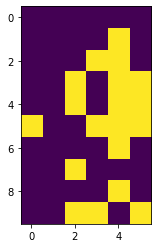

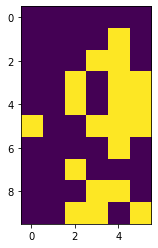

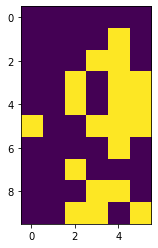

In [225]:
r, c = 7,3
plt.imshow(embedding_list[0][r,c,...,2])
plt.figure()
plt.imshow(embedding_list[34][r,c,...,2])
plt.figure()
plt.imshow(embedding_list[72][r,c,...,2])

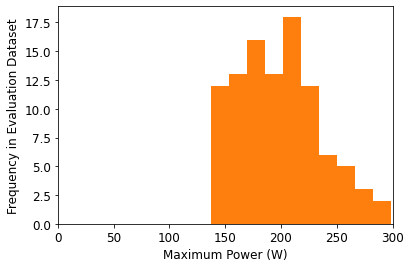

In [235]:
fig, ax = plt.subplots()
ax.hist(p_list, color='C1')
ax.set_xlabel('Maximum Power (W)',fontsize='large')
ax.set_ylabel('Frequency in Evaluation Dataset',fontsize='large')
ax.tick_params(axis='both', labelsize='large')
ax.set_xlim(0,300)
fig.savefig('histogram.png',dpi=300,bbox_inches="tight")

In [234]:
''' save model checkpoint '''

# set model checkpoint path inc. hyperparams
_path = 'supervised-f{}-k{}-z{}-conflict{}-no{}-batch{}.pth'.format(8,3,256,72,1112,24)
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
}, _path)


In [184]:
""" load model checkpoint """
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = 'supervised-f8-k3-z256-conflict10.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()